# Contact maps
In this notebook we calculate the contact maps between two masks. Contacts are defined with a distance cutoff between the alpha carbons of two residues.

In [1]:
import numpy as np
import mdtraj as md
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
%matplotlib inline
import uncertainties.unumpy as unumpy

## Loading function

In [2]:
def load_Trajs_generator(trajfiles_list, prmtop_file, stride, chunk):
    """
    Iteratively loads a list of NetCDF files and returns them
    as an iterable of mdtraj.Trajectory objects
    Parameters
    ----------
    trajfiles_list: list of str
            List with the names of trajectory files
    prmtop_file:  str
            Name of the prmtop file
    stride: int
            Frames to be used when loading the trajectories
    chunk:  int
            Number of frames to load at once from disk per iteration.
            If 0, load all.
    Yields
    ------
    frag: mdtraj.Trajectory
    """
    try:
        for traj in trajfiles_list:
            for frag in md.iterload(traj, chunk=chunk, top=prmtop_file,
                                    stride=stride):
                yield frag
    except OSError:
        # User passed a single long trajectory as a string
        # so there's no need to iterate through it.
        for frag in md.iterload(trajfiles_list, chunk=chunk, top=prmtop_file,
                                stride=stride):
            yield frag

## Contact map functions

In [3]:
def get_residuepairs(start1, end1, start2, end2, verbose=False):
    """
    Takes the beggining and end of two masks (0-indexed) and returns them as
    two lists, as well as the cartesian product between them.
    Parameters
    ----------
    start1: int
        Beggining of first mask
    end1: int
        End of first mask
    start2: int
        Beggining of second mask
    end2: int
        End of second mask
    Returns
    -------
    mask1: list of int
    mask2: list of int
    pairs: list of tuples
    """
    mask1 = list(range(start1, end1 + 1))
    mask2 = list(range(start2, end2 + 1))
    pairs = list(itertools.product(mask1, mask2))
    if verbose:
        print('Mask1 has %d residues\n' % (end1 - start1 + 1))
        print('Mask2 has %d residues\n' % (end2 - start2 + 1))
        print('Number of residue-residue interactions that will be considered:%d\n'
              % len(pairs))
    return(mask1, mask2, pairs)


def cmap_MDtraj(traj_generator, mask1, mask2, pairs, distance_cutoff=7, scheme='ca'):
    """
    Returns a contact map between two masks. Contacts between two residues
    range between 0 (if never present) and 1 (if present in all frames).
    Parameters
    ----------
    traj_generator: generator
        MD trajectory as obtained through the load_Trajs_generator() function
    mask1, mask2, pairs:
        Two masks and the corresponding residue-residue list of tuples
        as obtained from the get_residuepairs() function
    distance_cutoff: int
        Distance value (in Å) to meet the criteria of contact.
    scheme: str
        Any of the three schemes allowed by md.compute_contacts
        ['ca', 'closest', 'closest-heavy']
    Returns
    -------
    contact_frequency: np.array w/ shape (len(mask1), len(mask2))
        Contact map between mask1 and mask2. Can be used directly as
        input by the sns.heatmap() function.
    """
    # store the partial sum of contacts
    frequency = np.zeros((len(mask1), len(mask2)))
    count = 0  # Keep the frame count
    for traj_chunk in traj_generator:
        count += traj_chunk.n_frames
        distances_inChunk = md.compute_contacts(traj_chunk, pairs,
                                                scheme=scheme)
        # Sum by column
        # Divide the cutoff by 10 as mdtraj uses nm instead of Å
        column_sum = (distances_inChunk[0] <= distance_cutoff / 10).sum(0)
        # Sum the partial result to frequency
        frequency += column_sum.reshape(len(mask1), len(mask2))
    contact_frequency = frequency / count
    # Total contact value for each residue-residue pair. From 0 to 1.
    return(contact_frequency)


## Plotting functions

In [10]:
def renumber_mask(mask):
    """
    Renumbers the mask to match the correct sequence of each
    subunit. Also takes into account the 0-indexed lists of
    Python.
    """
    if max(mask) > 160 and max(mask) < 249:
        # It's in cTnT
        new_mask = [x + 51 for x in mask]
    elif max(mask) >= 249:
        # It's in cTnI
        new_mask = [x - 247 for x in mask]
    else:
        # It's in cTnC
        new_mask = [x + 1 for x in mask]
    return(new_mask)


def plot_heatmap(contact_array, mask1, mask2, title=None, save=True,
                 x_label=None, y_label=None,
                 x_steps=True, y_steps=True,
                 min_value=0, max_value=1,
                 std_array=None):
    """
    Plot a single heatmap on a red color scale.
    """
    if std_array is not None:
        # Make figure bigger as the annotation takes a lot of space
        fig, ax = plt.subplots(figsize=(20, 20))
    else:
        fig, ax = plt.subplots(figsize=(10, 10))
    # Check what part of cTn mask1 is in and renumber accordingly
    new_mask1 = renumber_mask(mask1)
    new_mask2 = renumber_mask(mask2)

    # Convert to a pd.DataFrame so sns.heatmap() can read it's
    # row/column labels properly
    contact_df = pd.DataFrame(contact_array, index=new_mask2,
                              columns=new_mask1)

    if std_array is not None:
        ax = sns.heatmap(contact_df,
                         vmin=min_value,
                         vmax=max_value,
                         xticklabels=x_steps,
                         yticklabels=y_steps,
                         cmap='Reds',
                         linewidths=.5,
                         annot=std_array,
                         fmt='.2f',
                         annot_kws={
                             'rotation' : 'vertical'
                         })
    else:
        ax = sns.heatmap(contact_df,
                         vmin=min_value,
                         vmax=max_value,
                         xticklabels=x_steps,
                         yticklabels=y_steps,
                         cmap='Reds',
                         linewidths=.5)

    plt.gca().invert_yaxis()

    plt.xticks(rotation='horizontal')
    plt.yticks(rotation='horizontal')

    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    if save:
        if title is None:
            raise ValueError("Need a title to save the figure.")
        else:
            filename = title.replace(" ", "")
            filename += ".png"
            plt.savefig(filename, format='png', dpi=300)
    else:
        plt.show()


def plot_diffmap(contact_array, mask1, mask2, title=None, save=True,
                 x_label=None, y_label=None,
                 x_steps=True, y_steps=True,
                 std_array=None):
    """
    Plots a difference heatmap with a blue-grey-red diverging
    color scale.
    """
    if std_array is not None:
        # Make figure bigger as the annotation takes a lot of space
        fig, ax = plt.subplots(figsize=(20, 20))
    else:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Check what part of cTn mask1 is in and renumber accordingly
    new_mask1 = renumber_mask(mask1)
    new_mask2 = renumber_mask(mask2)

    contact_df = pd.DataFrame(contact_array, index=new_mask2,
                              columns=new_mask1)

    # Diverging palette with light colour on the middle
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    if std_array is not None:
        ax = sns.heatmap(contact_df,
                         vmin=contact_array.min(),
                         vmax=contact_array.max(),
                         xticklabels=x_steps,
                         yticklabels=y_steps,
                         annot=std_array,
                         mask=std_array <= 0.01,  # Only values GE 0.01 will be displayed
                         fmt='.2f',
                         annot_kws={
                            'rotation' : 'vertical'
                         },
                         cmap=cmap,
                         linewidths=.5)
    else:
        ax = sns.heatmap(contact_df,
                         vmin=contact_array.min(),
                         vmax=contact_array.max(),
                         xticklabels=x_steps,
                         yticklabels=y_steps,
                         cmap=cmap,
                         linewidths=.5)

    plt.gca().invert_yaxis()
    plt.xticks(rotation='horizontal')
    plt.yticks(rotation='horizontal')

    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    if save:
        if title is None:
            raise ValueError("Need a title to save the figure.")
        else:
            filename = title.replace(" ", "")
            filename += ".png"
            plt.savefig(filename, format='png', dpi=300)
    else:
        plt.show()


Provide the trajectories with glob expression. Provide the matching topology as a string.

In [5]:
wt_filelist = sorted(glob(
        "/Users/je714/Troponin/IAN_Troponin/completehowarthcut/salted/ff99SB/*SALT*/*/noIONS*nc"))
wt_top = "/Users/je714/Troponin/IAN_Troponin/completehowarthcut/salted/ff99SB/WT_ff9SB_noIons.prmtop"
s1p_filelist = sorted(glob("/Users/je714/Troponin/IAN_Troponin/completehowarthcut/phospho/hmr_runs/CTn*/*/S1P/noIONS*nc"))
s1p_top = "/Users/je714/Troponin/IAN_Troponin/completehowarthcut/phospho/hmr_runs/repstr.c0_phosS1P_nowat_noIONS.prmtop"
sep_filelist = sorted(glob("/Users/je714/Troponin/IAN_Troponin/completehowarthcut/phospho/hmr_runs/CTn*/*/SEP/noIONS*nc"))
sep_top = "/Users/je714/Troponin/IAN_Troponin/completehowarthcut/phospho/hmr_runs/repstr.c0_phosSEP_nowat_noIONS.prmtop"

The interactions between the following regions are calculated:

The interactions between the following regions were calculated:
   - NcTnC (cTnC1-89) with NcTnI (cTnI1-41)
   - NcTnC with switch peptide (cTnI148-164)
   - cTnC1-161 with the inhibitory peptide (cTnI138-147)
   - The inhibitory peptide with NcTnI
   - CcTnT (cTnT282-298) with NcTnI
   - CcTnT with the inhibitory peptide.

Python uses 0-indexed lists and the numbering below is matching the 419 amino acid cTn model.

In [6]:
CcTnT,  inhib, CcTnT_inhib  =   get_residuepairs(231, 247, 385, 394)
CcTnT,  NcTnI, CcTnT_NcTnI  =   get_residuepairs(231, 247, 248, 288)
NcTnC,  NcTnI, NcTnC_NcTnI  =   get_residuepairs(  0,  88, 248, 288)
NcTnC, switch, NcTnC_switch =   get_residuepairs(  0,  88, 395, 411)
NcTnI,  inhib, NcTnI_inhib  =   get_residuepairs(248, 288, 385, 394)
cTnC,   inhib, cTnC_inhib   =   get_residuepairs(  0, 160, 385, 394)

We store the masks and the pairs in a list to iterate through them easily.

In [7]:
region_list = [
    [CcTnT,  inhib, CcTnT_inhib, 'CcTnT - inhibitory peptide'],
    [CcTnT,  NcTnI, CcTnT_NcTnI, 'CcTnT - NcTnI'],
    [NcTnC,  NcTnI, NcTnC_NcTnI, 'NcTnC - NcTnI'],
    [NcTnC, switch, NcTnC_switch, 'NcTnC - switch peptide'],
    [NcTnI,  inhib, NcTnI_inhib, 'NcTnI - inhibitory peptide'],
    [cTnC,   inhib, cTnC_inhib, 'cTnC - inhibitory peptide']
]

### Calculate the contact maps
The `stride` variable can be increased to speed up the calculation. I have tested values between 1 and 10 and no apparent difference from the maps can be made out (10 frames is 200 ps so it shouldn't make that much of a difference anyway).

In [8]:
stride = 10
chunk = 250
cutoff = 7

We have to re-load the trajectories at each point because they are stored in a generator object.

In [9]:
wt_maps = []
s1p_maps = []
sep_maps = []

for region in region_list:
    wt_trjs  = load_Trajs_generator(trajfiles_list=wt_filelist,
                                    prmtop_file=wt_top, stride=stride, chunk=chunk)
    s1p_trjs = load_Trajs_generator(trajfiles_list=s1p_filelist,
                                    prmtop_file=s1p_top, stride=stride, chunk=chunk)
    sep_trjs = load_Trajs_generator(trajfiles_list=sep_filelist,
                                    prmtop_file=sep_top, stride=stride, chunk=chunk)
    wt_maps.append(cmap_MDtraj(wt_trjs, mask1=region[0], mask2=region[1],
                               pairs=region[2], distance_cutoff=cutoff))
    s1p_maps.append(cmap_MDtraj(s1p_trjs, mask1=region[0], mask2=region[1],
                               pairs=region[2], distance_cutoff=cutoff))
    sep_maps.append(cmap_MDtraj(sep_trjs, mask1=region[0], mask2=region[1],
                               pairs=region[2], distance_cutoff=cutoff))

## Generate the plots

#### CcTnT - inhibitory peptide

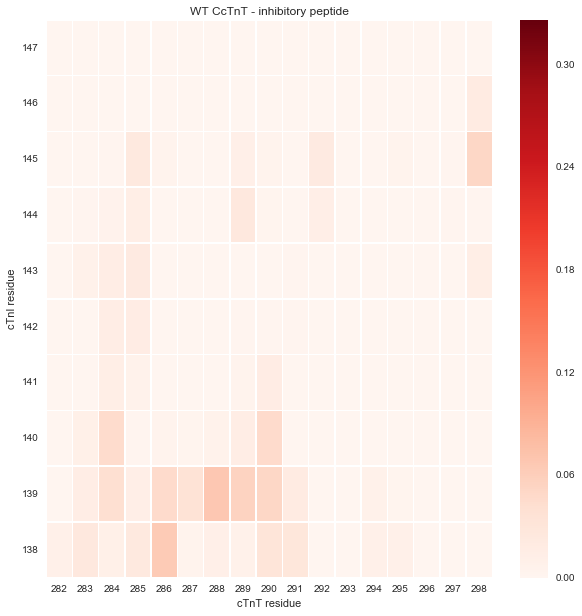

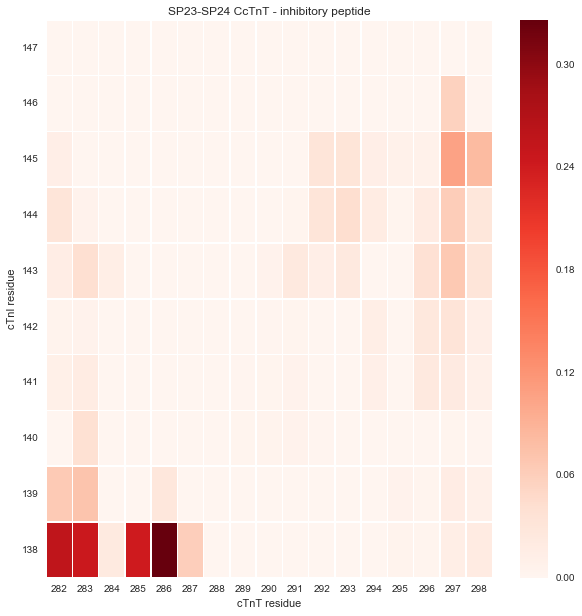

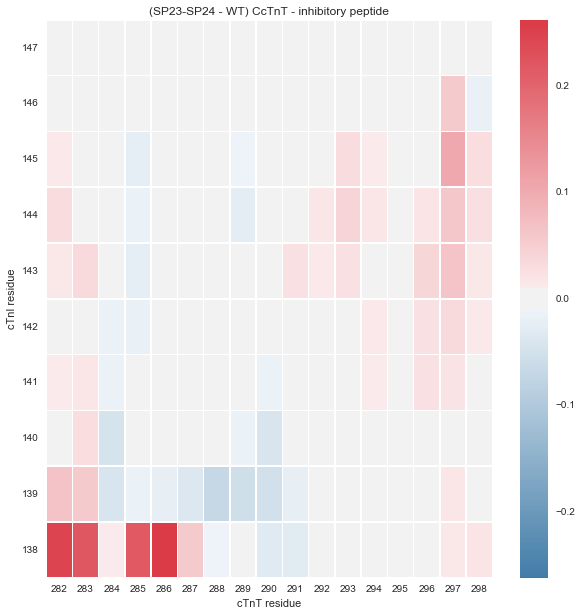

In [11]:
p_map_avg_CcTnT_inhib = (s1p_maps[0] + sep_maps[0]) / 2
single_max = max(wt_maps[0].max(), p_map_avg_CcTnT_inhib.max())
plot_heatmap(wt_maps[0].T, mask1=CcTnT, mask2=inhib,
             x_steps=True, y_steps=True,
             x_label='cTnT residue',
             y_label='cTnI residue',
             title='WT CcTnT - inhibitory peptide',
             max_value=single_max)
plot_heatmap(p_map_avg_CcTnT_inhib.T, mask1=CcTnT, mask2=inhib,
             x_steps=True, y_steps=True,
             x_label='cTnT residue',
             y_label='cTnI residue',
             title='SP23-SP24 CcTnT - inhibitory peptide',
             max_value=single_max)
plot_diffmap(p_map_avg_CcTnT_inhib.T - wt_maps[0].T,
             mask1=CcTnT, mask2=inhib,
             x_steps=True,
             y_steps=True,
             x_label='cTnT residue',
             y_label='cTnI residue',
             title='(SP23-SP24 - WT) CcTnT - inhibitory peptide')

#### CcTnT - NcTnI

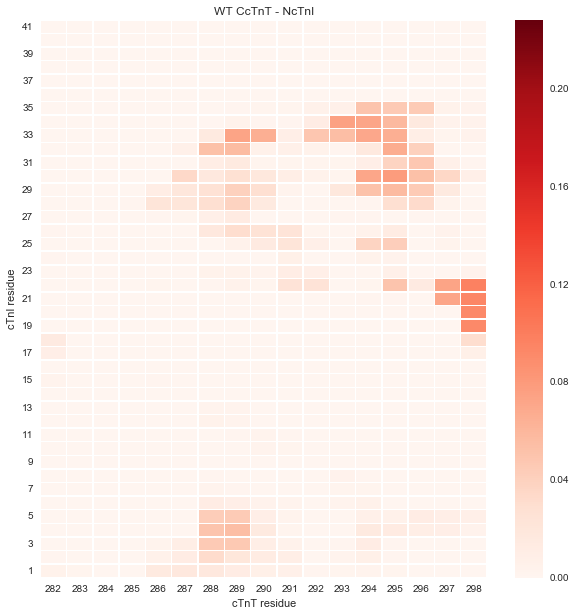

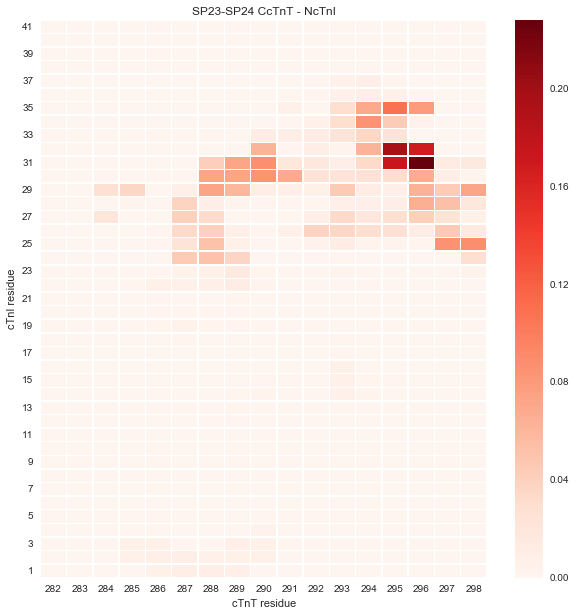

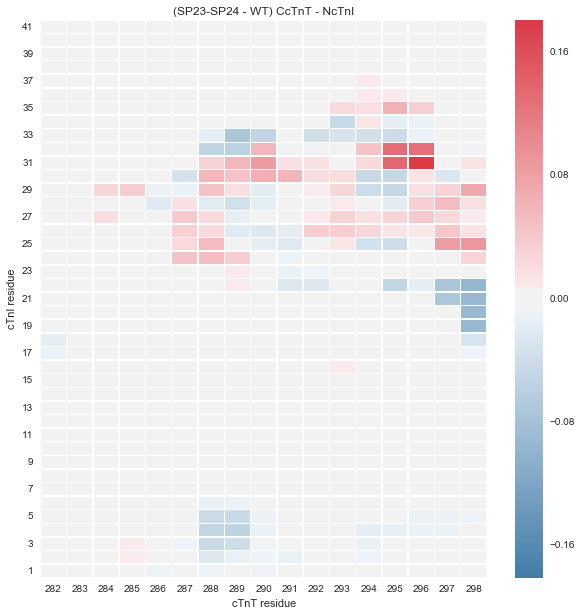

In [12]:
p_map_avg_CcTnT_NcTnI = (s1p_maps[1] + sep_maps[1]) / 2
single_max = max(wt_maps[1].max(), p_map_avg_CcTnT_NcTnI.max())
plot_heatmap(wt_maps[1].T, mask1=CcTnT, mask2=NcTnI,
             x_steps=True, y_steps=2,
             x_label='cTnT residue',
             y_label='cTnI residue',
             title='WT CcTnT - NcTnI',
             max_value=single_max)
plot_heatmap(p_map_avg_CcTnT_NcTnI.T, mask1=CcTnT, mask2=NcTnI,
             x_steps=True, y_steps=2,
             x_label='cTnT residue',
             y_label='cTnI residue',
             title='SP23-SP24 CcTnT - NcTnI',
             max_value=single_max)
plot_diffmap(p_map_avg_CcTnT_NcTnI.T - wt_maps[1].T,
             mask1=CcTnT, mask2=NcTnI,
             x_steps=True,
             y_steps=2,
             x_label='cTnT residue',
             y_label='cTnI residue',
             title='(SP23-SP24 - WT) CcTnT - NcTnI')


#### NcTnC - NcTnI

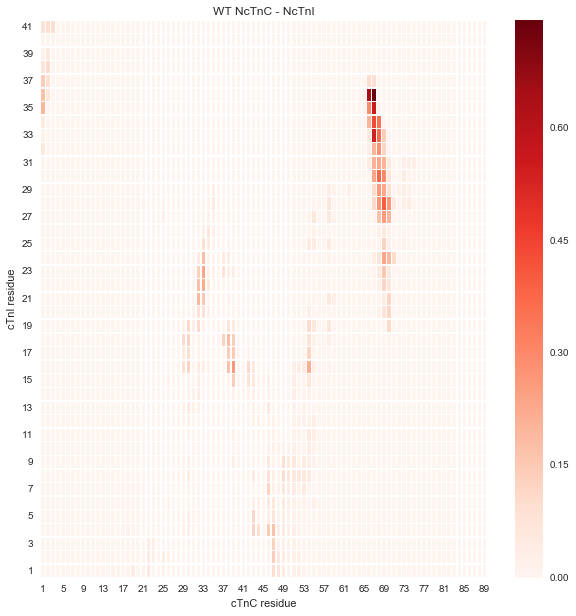

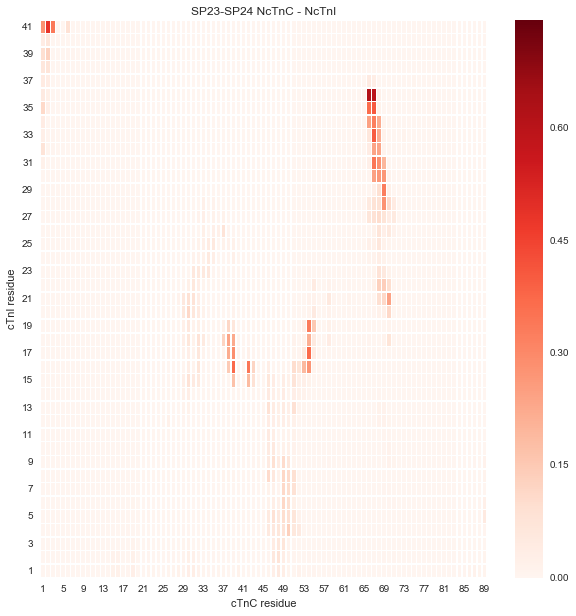

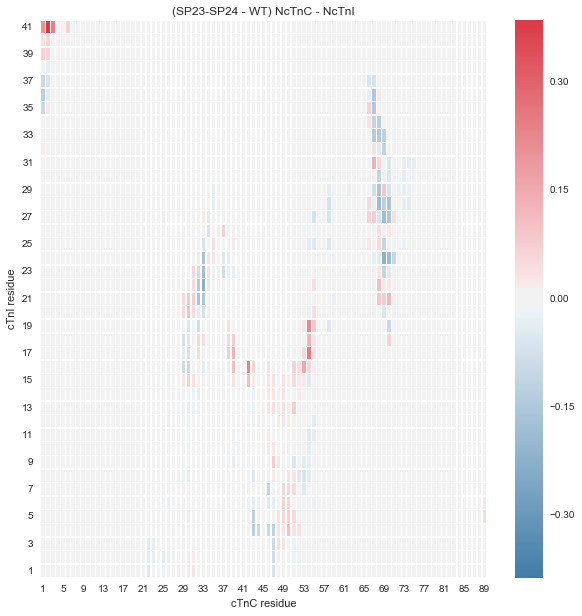

In [13]:
p_map_avg_NcTnC_NcTnI = (s1p_maps[2] + sep_maps[2]) / 2
single_max = max(wt_maps[2].max(), p_map_avg_NcTnC_NcTnI.max())
plot_heatmap(wt_maps[2].T, mask1=NcTnC, mask2=NcTnI,
             x_steps=4, y_steps=2,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='WT NcTnC - NcTnI',
             max_value=single_max)
plot_heatmap(p_map_avg_NcTnC_NcTnI.T, mask1=NcTnC, mask2=NcTnI,
             x_steps=4, y_steps=2,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='SP23-SP24 NcTnC - NcTnI',
             max_value=single_max)
plot_diffmap(p_map_avg_NcTnC_NcTnI.T - wt_maps[2].T,
             mask1=NcTnC, mask2=NcTnI,
             x_steps=4,
             y_steps=2,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='(SP23-SP24 - WT) NcTnC - NcTnI')


#### NcTnC - switch peptide

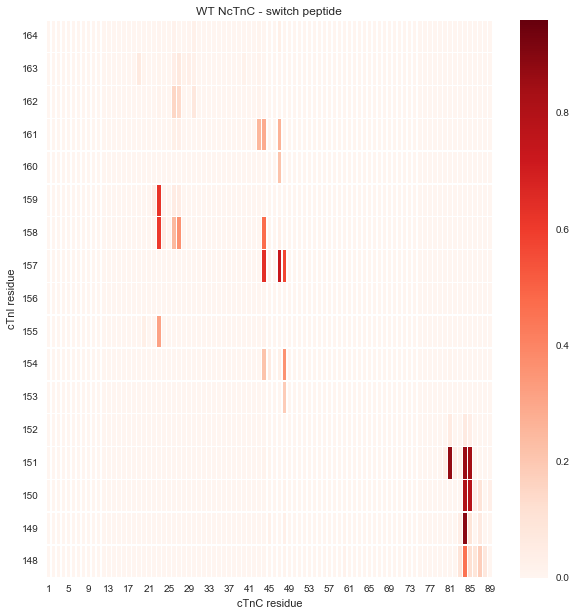

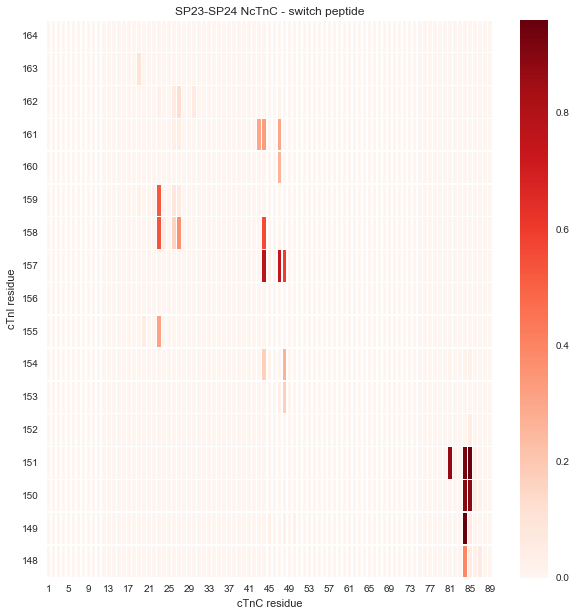

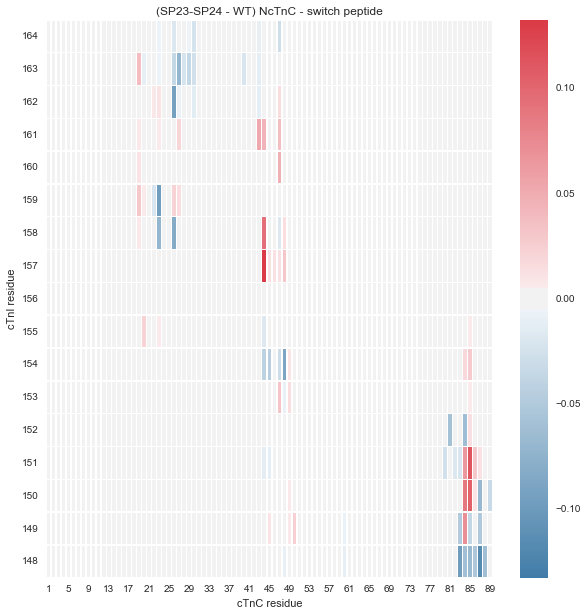

In [14]:
p_map_avg_NcTnC_switch = (s1p_maps[3] + sep_maps[3]) / 2
single_max = max(wt_maps[3].max(), p_map_avg_NcTnC_switch.max())
plot_heatmap(wt_maps[3].T, mask1=NcTnC, mask2=switch,
             x_steps=4, y_steps=True,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='WT NcTnC - switch peptide',
             max_value=single_max)
plot_heatmap(p_map_avg_NcTnC_switch.T, mask1=NcTnC, mask2=switch,
             x_steps=4, y_steps=True,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='SP23-SP24 NcTnC - switch peptide',
             max_value=single_max)
plot_diffmap(p_map_avg_NcTnC_switch.T - wt_maps[3].T,
             mask1=NcTnC, mask2=switch,
             x_steps=4,
             y_steps=True,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='(SP23-SP24 - WT) NcTnC - switch peptide')

#### NcTnI - inhibitory peptide

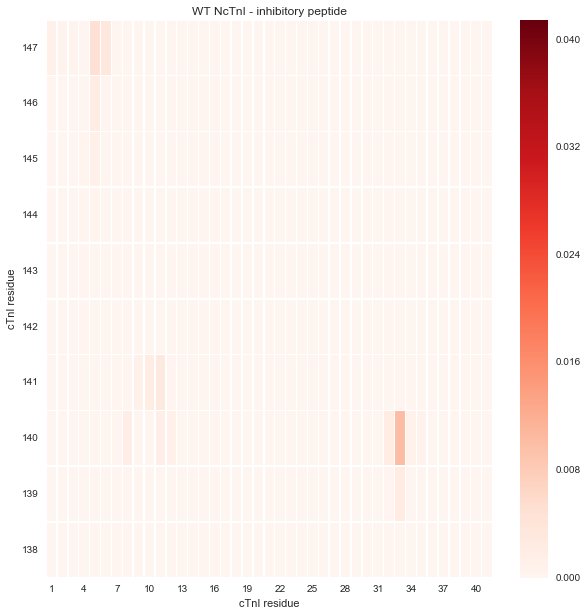

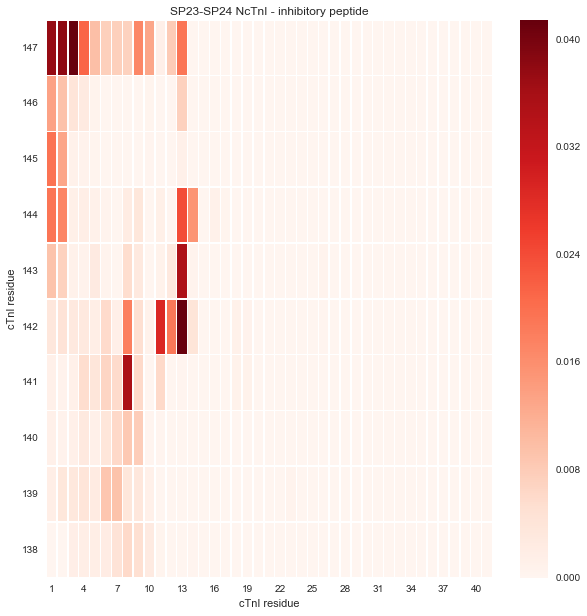

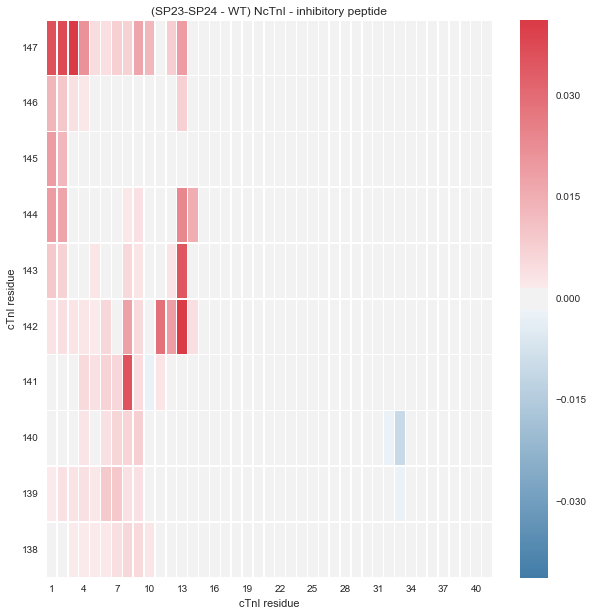

In [15]:
p_map_avg_NcTnI_inhib = (s1p_maps[4] + sep_maps[4]) / 2
single_max = max(wt_maps[4].max(), p_map_avg_NcTnI_inhib.max())
plot_heatmap(wt_maps[4].T, mask1=NcTnI, mask2=inhib,
             x_steps=3, y_steps=True,
             x_label='cTnI residue',
             y_label='cTnI residue',
             title='WT NcTnI - inhibitory peptide',
             max_value=single_max)
plot_heatmap(p_map_avg_NcTnI_inhib.T, mask1=NcTnI, mask2=inhib,
             x_steps=3, y_steps=True,
             x_label='cTnI residue',
             y_label='cTnI residue',
             title='SP23-SP24 NcTnI - inhibitory peptide',
             max_value=single_max)
plot_diffmap(p_map_avg_NcTnI_inhib.T - wt_maps[4].T,
             mask1=NcTnI, mask2=inhib,
             x_steps=3,
             y_steps=True,
             x_label='cTnI residue',
             y_label='cTnI residue',
             title='(SP23-SP24 - WT) NcTnI - inhibitory peptide')


#### cTnC - inhibitory peptide

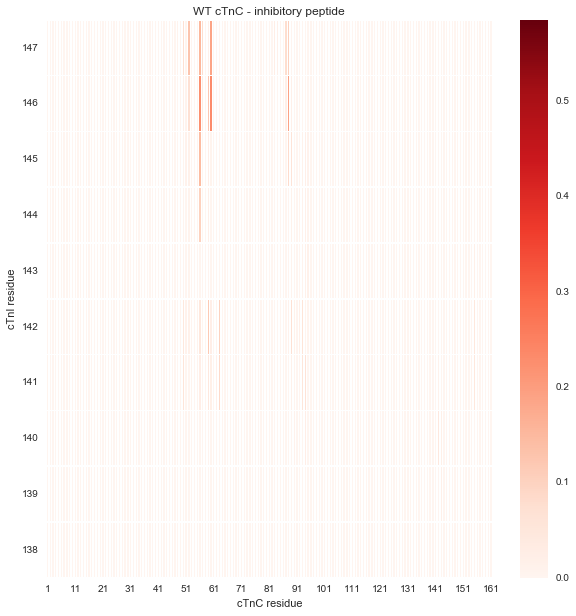

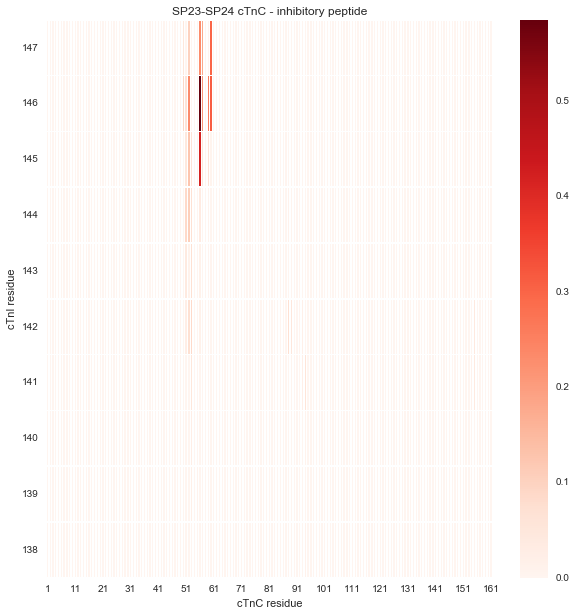

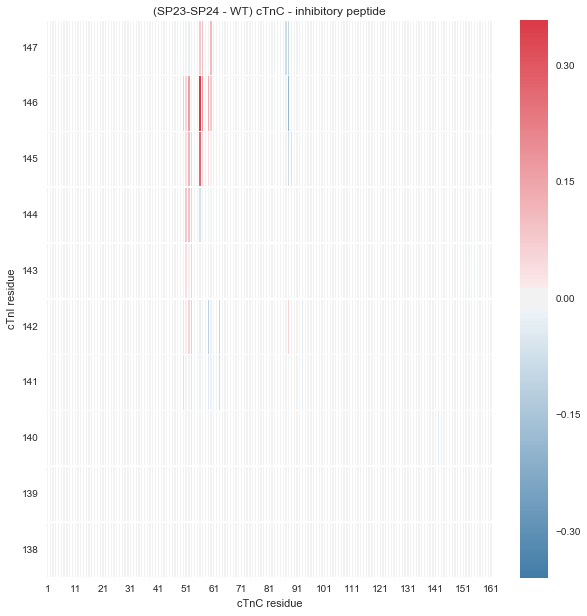

In [16]:
p_map_avg_cTnC_inhib = (s1p_maps[5] + sep_maps[5]) / 2
single_max = max(wt_maps[5].max(), p_map_avg_cTnC_inhib.max())
plot_heatmap(wt_maps[5].T, mask1=cTnC, mask2=inhib,
             x_steps=10, y_steps=True,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='WT cTnC - inhibitory peptide',
             max_value=single_max)
plot_heatmap(p_map_avg_cTnC_inhib.T, mask1=cTnC, mask2=inhib,
             x_steps=10, y_steps=True,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='SP23-SP24 cTnC - inhibitory peptide',
             max_value=single_max)
plot_diffmap(p_map_avg_cTnC_inhib.T - wt_maps[5].T,
             mask1=cTnC, mask2=inhib,
             x_steps=10,
             y_steps=True,
             x_label='cTnC residue',
             y_label='cTnI residue',
             title='(SP23-SP24 - WT) cTnC - inhibitory peptide')


## Dealing with variability in the runs
From the plots above, one can see the average trends in the two kinds of system. But the average value is only half of the picture.

What happens if we consider the interactions in each individual run? We can then get a sense of the uncertainty in the interactions.

In [17]:
i_wt_cmaps = []
i_s1p_cmaps = []
i_sep_cmaps = []

for region in region_list:
    for file in wt_filelist:
        trj = load_Trajs_generator(file, wt_top, stride=10, chunk=250)
        i_wt_cmaps.append(cmap_MDtraj(trj, region[0], region[1], region[2]))
    for file in s1p_filelist:
        trj = load_Trajs_generator(file, s1p_top, stride=10, chunk=250)
        i_s1p_cmaps.append(cmap_MDtraj(trj, region[0], region[1], region[2]))
    for file in sep_filelist:
        trj = load_Trajs_generator(file, sep_top, stride=10, chunk=250)
        i_sep_cmaps.append(cmap_MDtraj(trj, region[0], region[1], region[2]))

In [18]:
def select_plotParams_fromTitle(title):
    if title == 'CcTnT - inhibitory peptide':
        y_step = True
        x_step = True
        y_lab ='cTnI residue'
        x_lab ='cTnT residue'
    if title == 'CcTnT - NcTnI':
        y_step = 2
        x_step = True
        y_lab ='cTnI residue'
        x_lab ='cTnT residue'
    if title == 'NcTnC - NcTnI':
        y_step = 2
        x_step = 4
        y_lab ='cTnI residue'
        x_lab ='cTnC residue'
    if title == 'NcTnC - switch peptide':
        y_step = True
        x_step = 4
        y_lab ='cTnI residue'
        x_lab ='cTnC residue'
    if title == 'NcTnI - inhibitory peptide':
        y_step = True
        x_step = 3
        y_lab ='cTnI residue'
        x_lab ='cTnI residue'
    if title == 'cTnC - inhibitory peptide':
        y_step = True
        x_step = 10
        y_lab ='cTnI residue'
        x_lab ='cTnC residue'

    return(y_step, x_step, y_lab, x_lab)

In [19]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]

def individual_plots(split_map_list, region_list, system):
    for cmap_region, region in zip(split_map_list, region_list):
        y_step, x_step, y_lab, x_lab = select_plotParams_fromTitle(region[3])
        count=0
        single_max=0
        for cmap in cmap_region:
            single_max = max(single_max, cmap.max())
        for cmap in cmap_region:
            count += 1
            plot_heatmap(cmap.T, region[0], region[1],
                         title='%s %s run%02d' %  (system, region[3], count),
                         save=True,
                         x_steps=x_step, y_steps=y_step,
                         x_label=x_lab, y_label=y_lab,
                         max_value=single_max)

/Users/je714/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


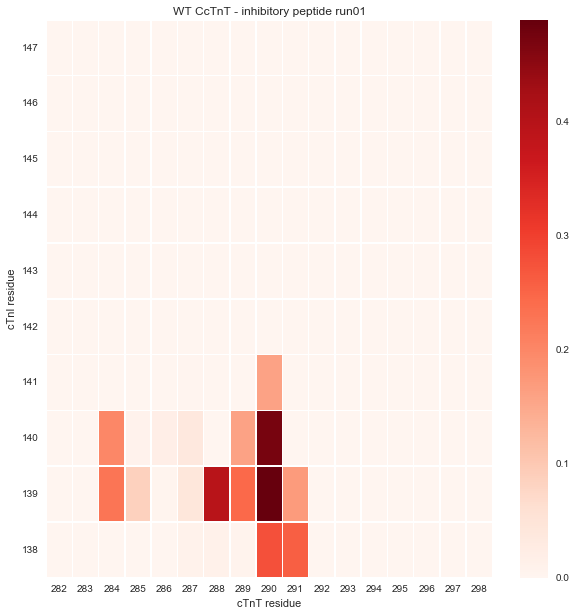

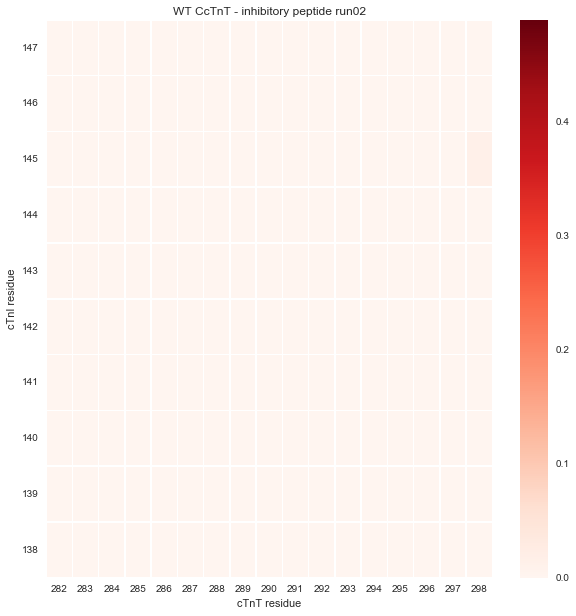

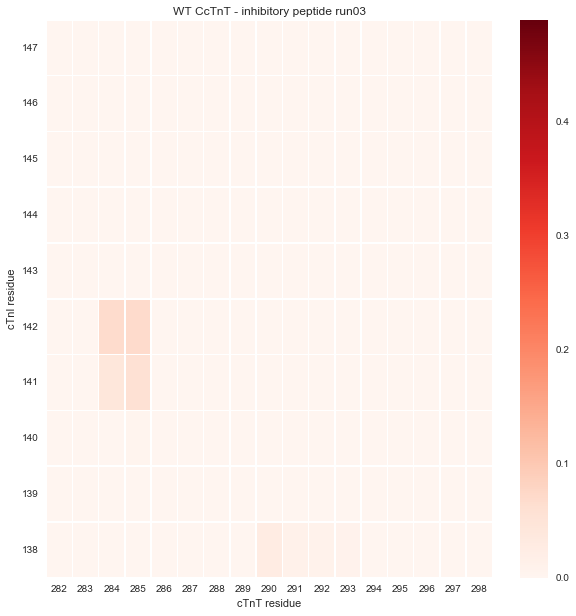

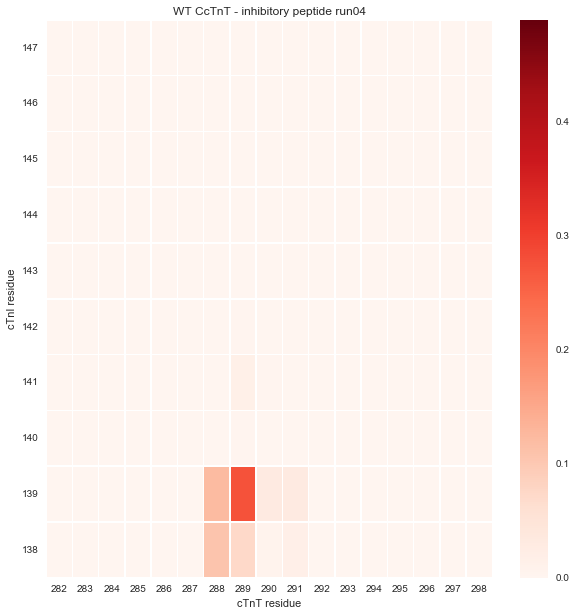

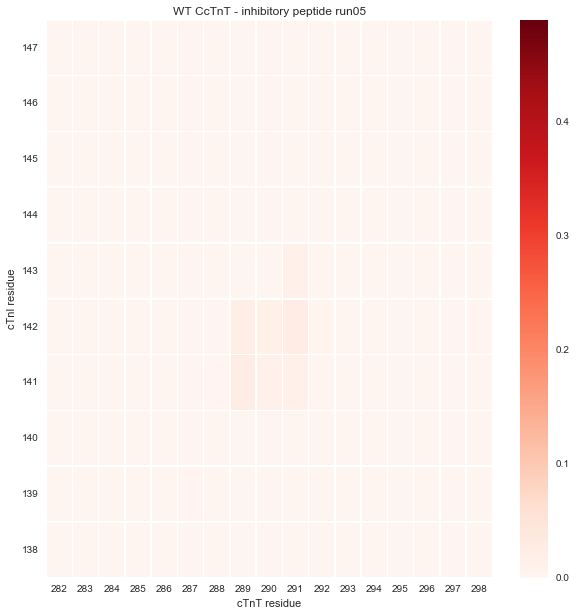

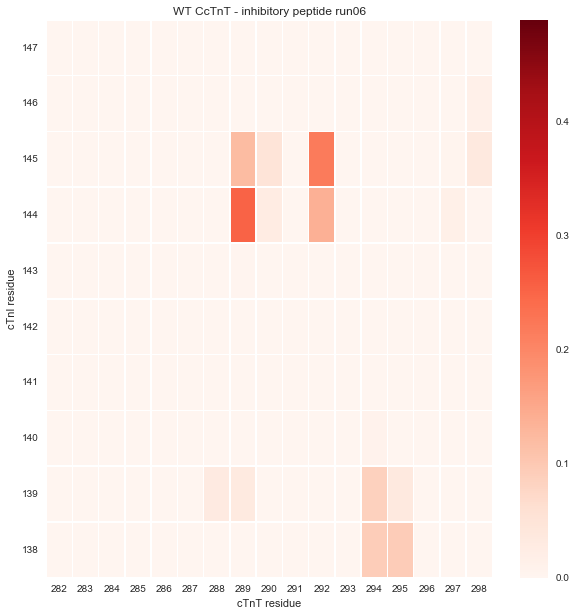

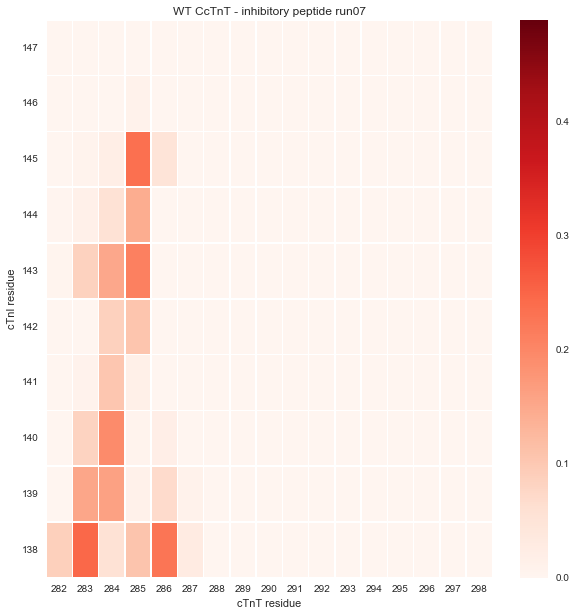

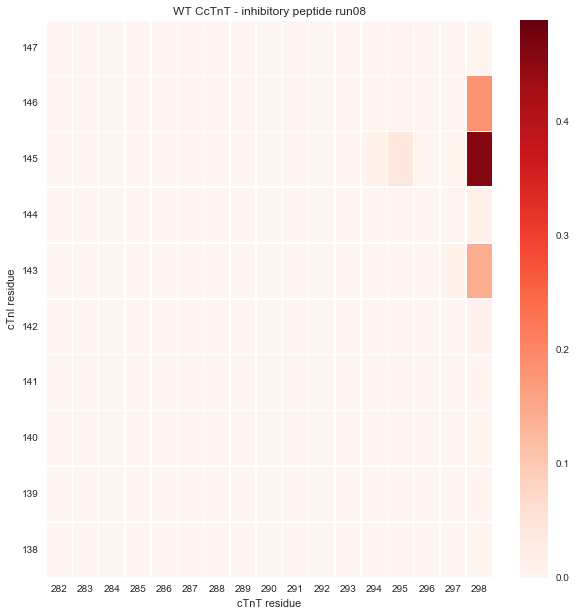

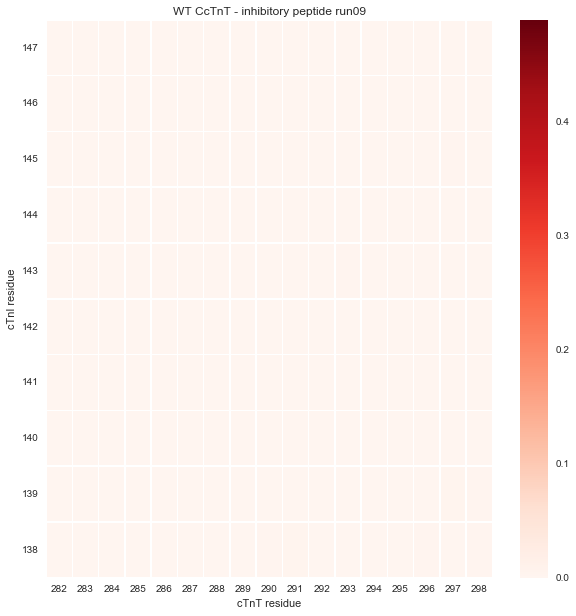

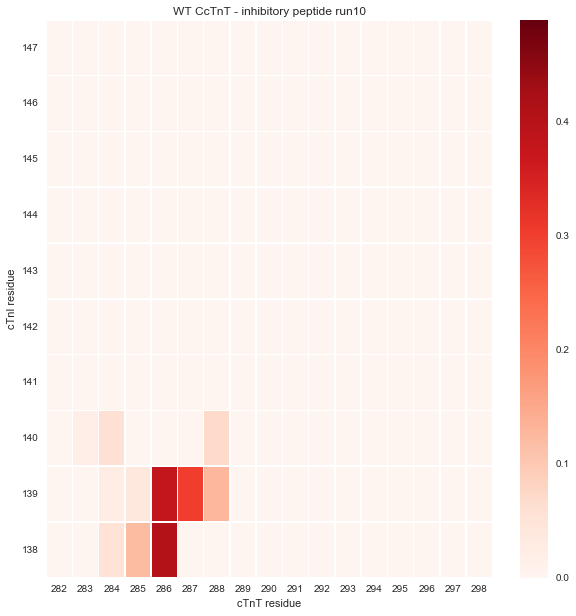

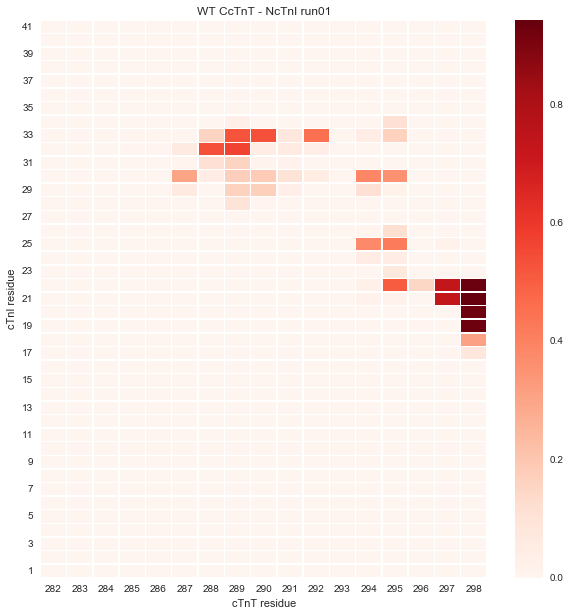

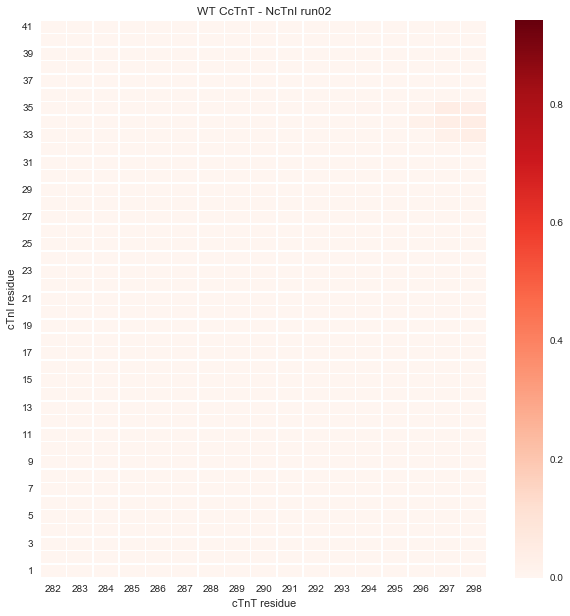

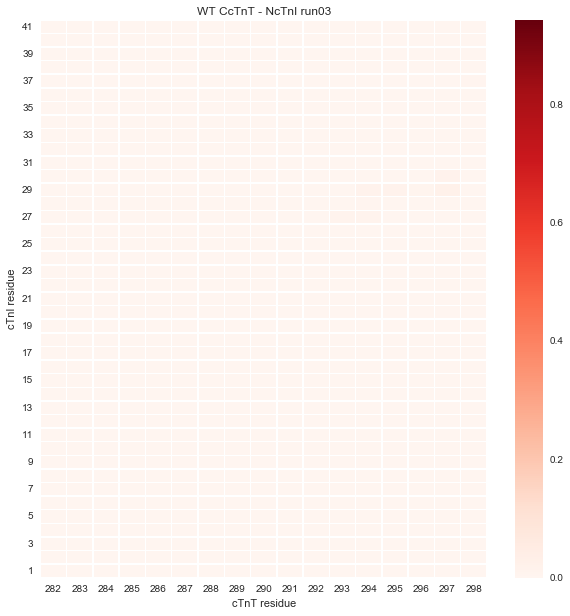

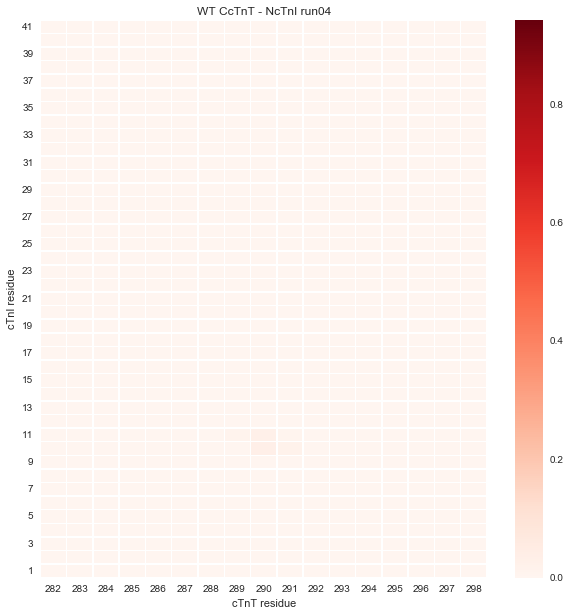

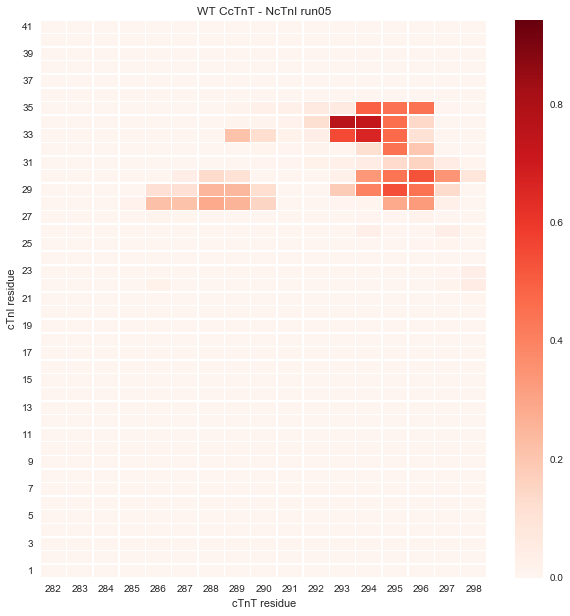

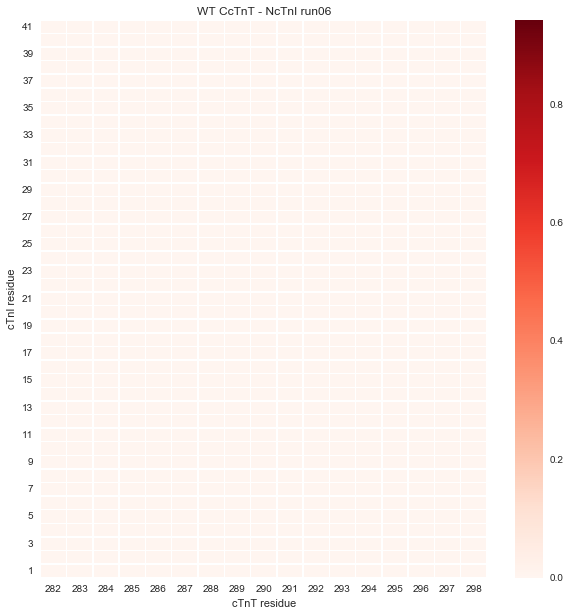

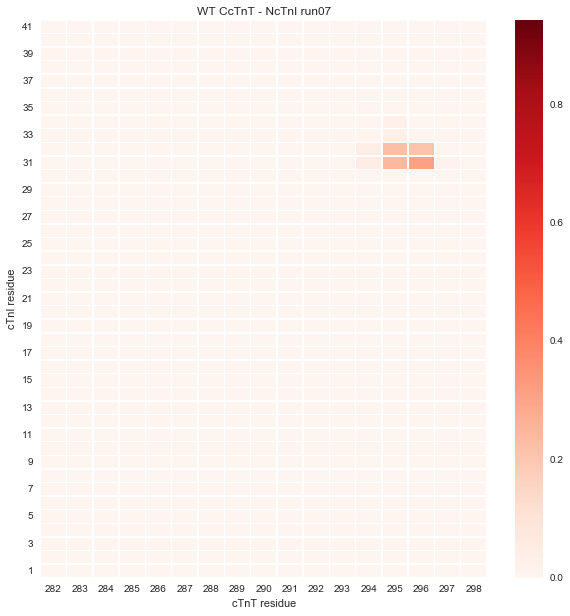

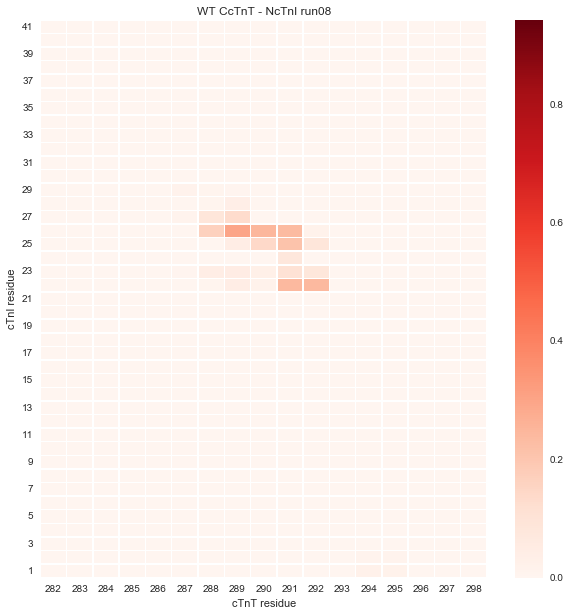

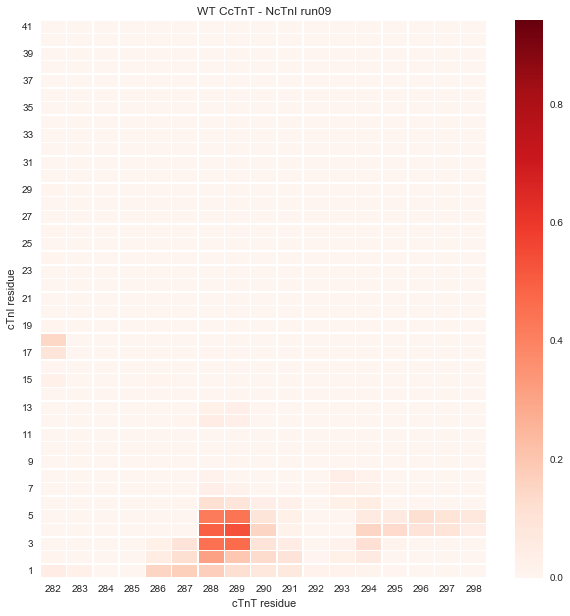

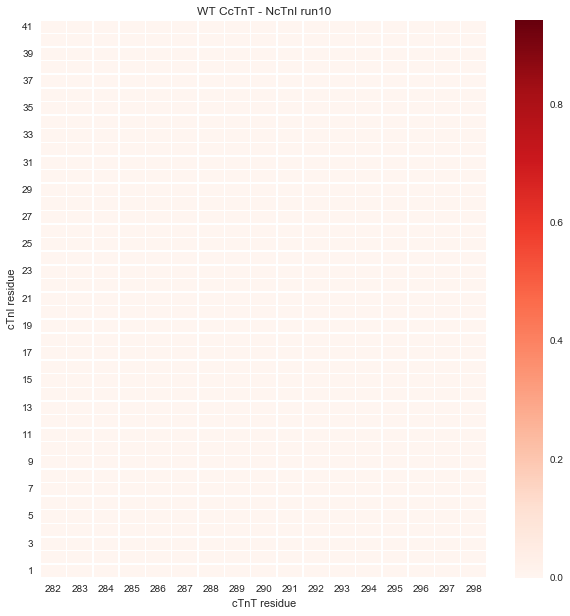

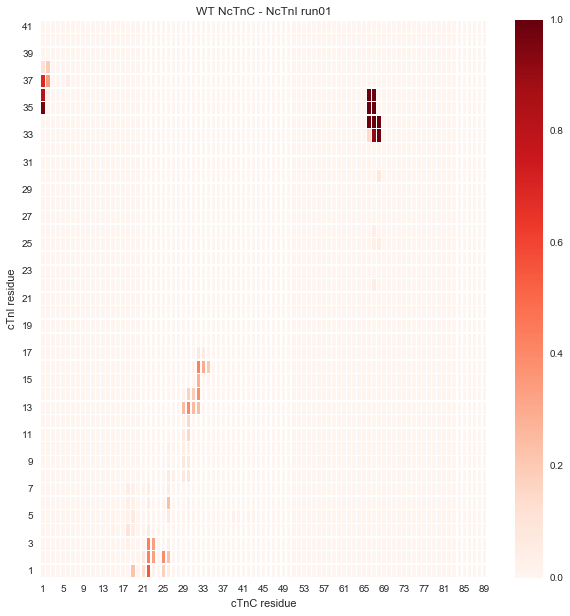

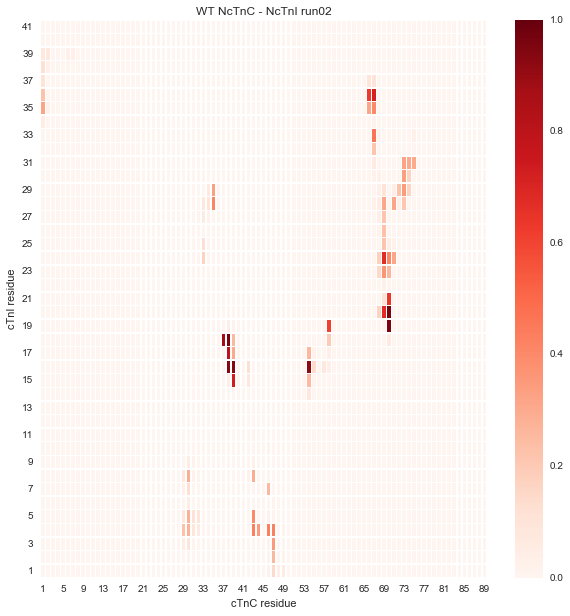

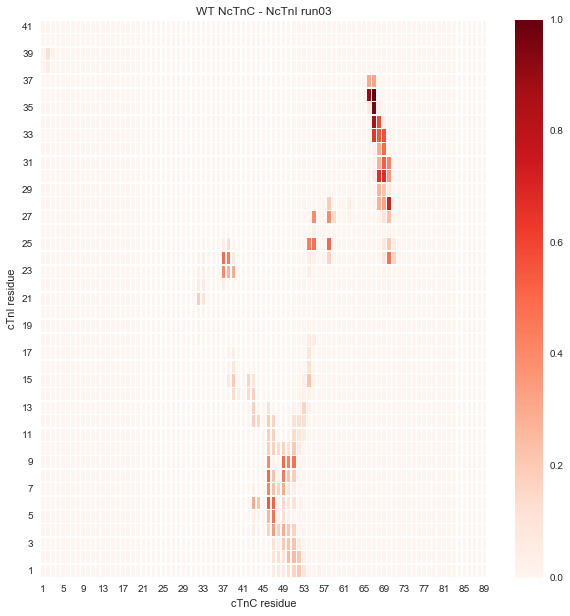

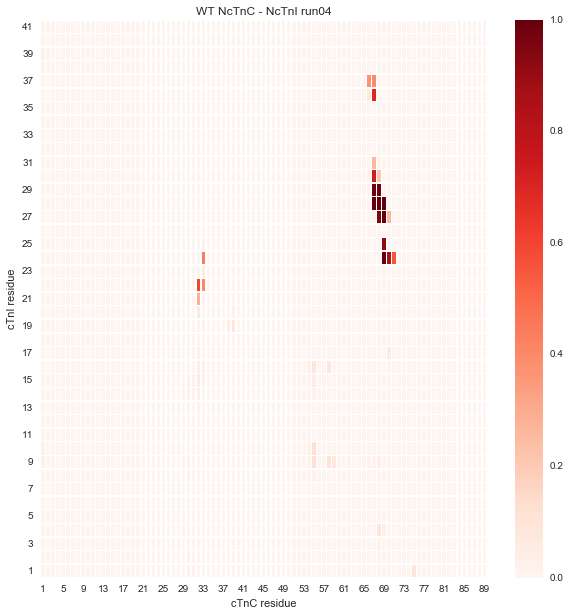

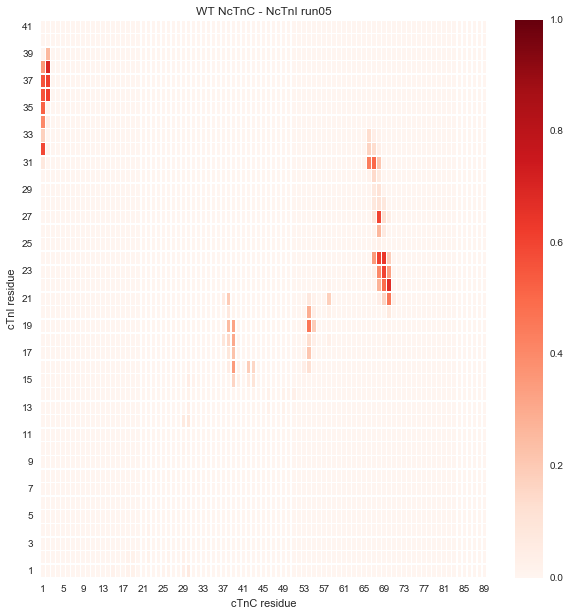

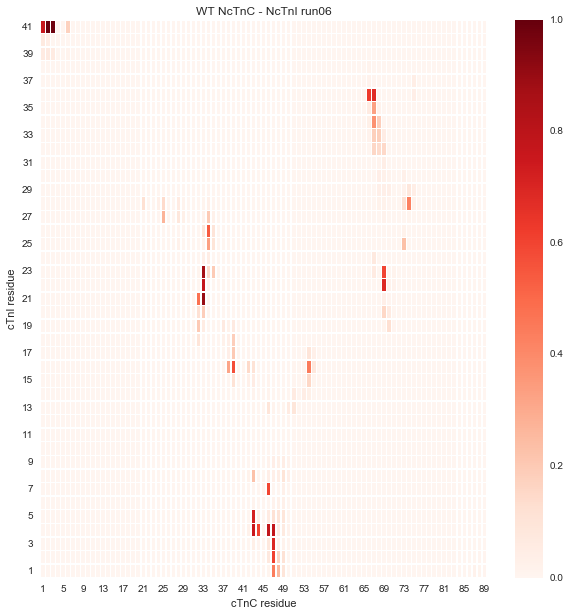

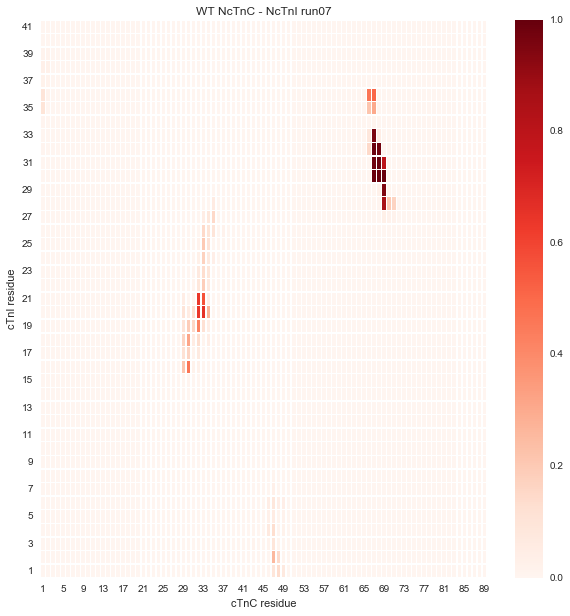

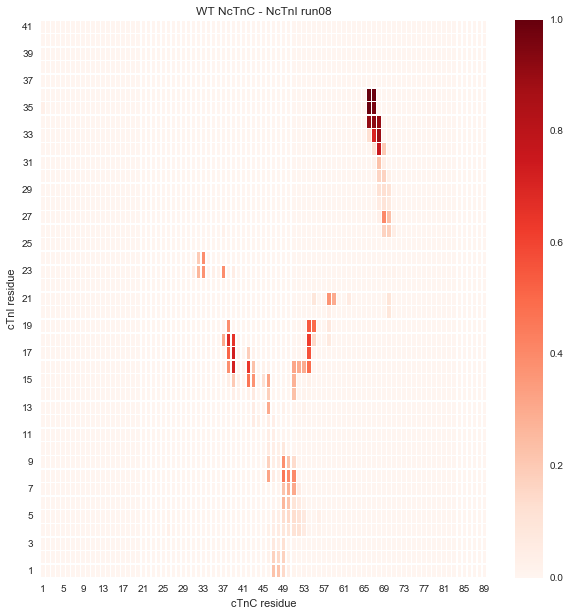

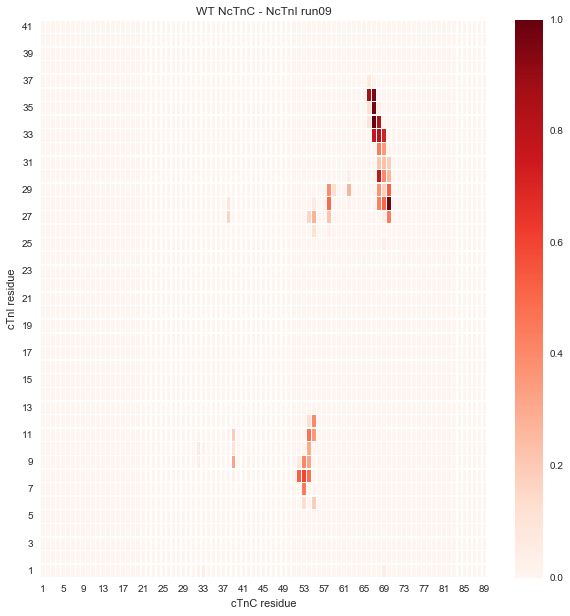

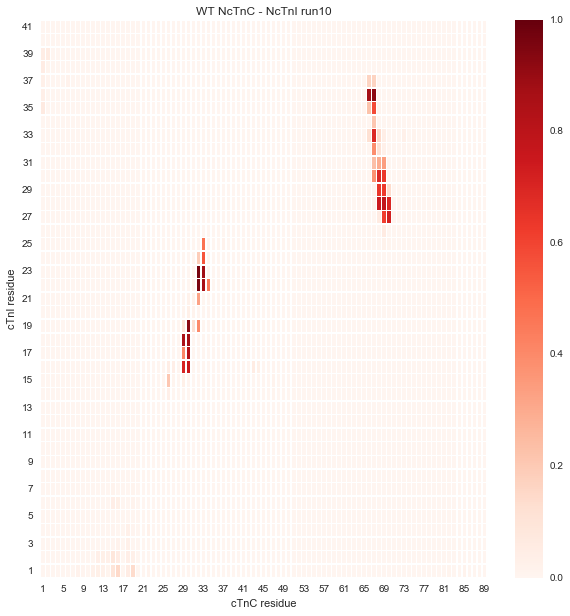

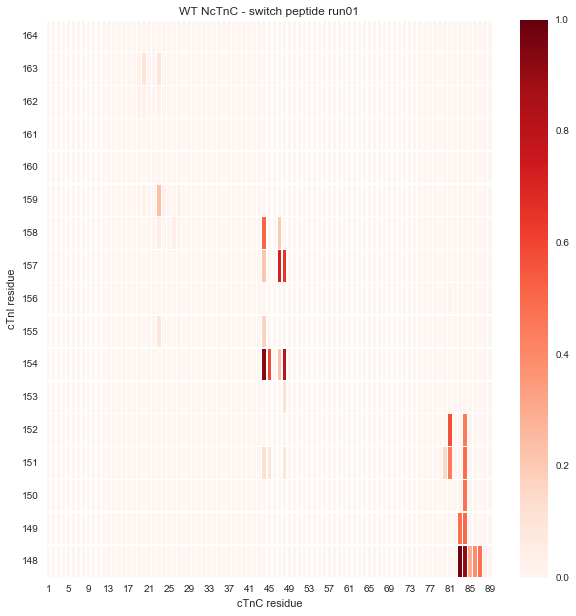

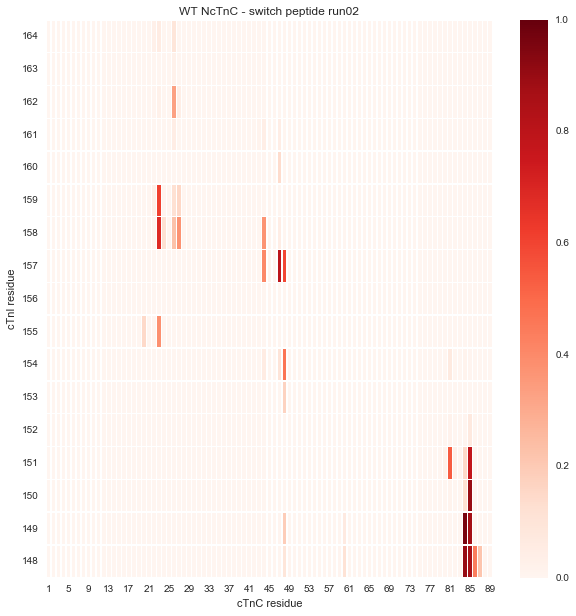

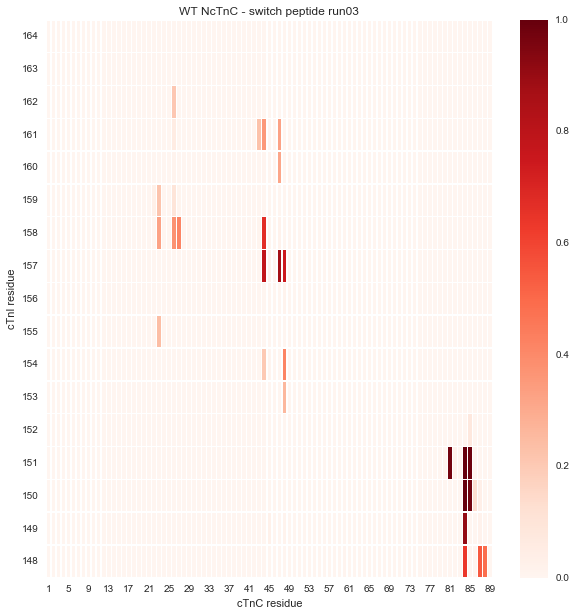

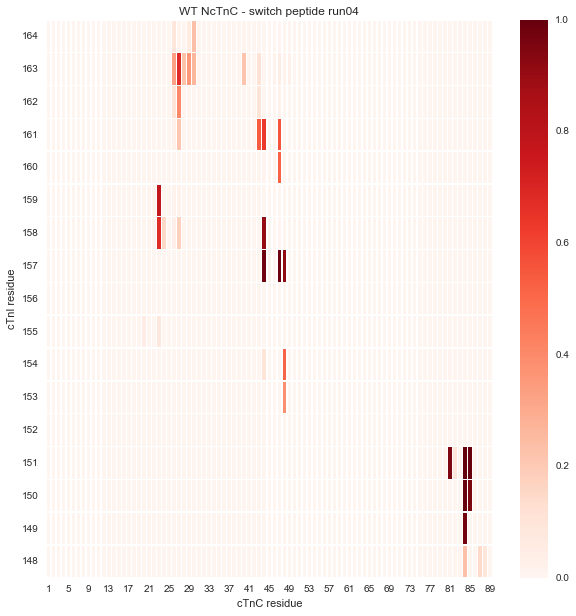

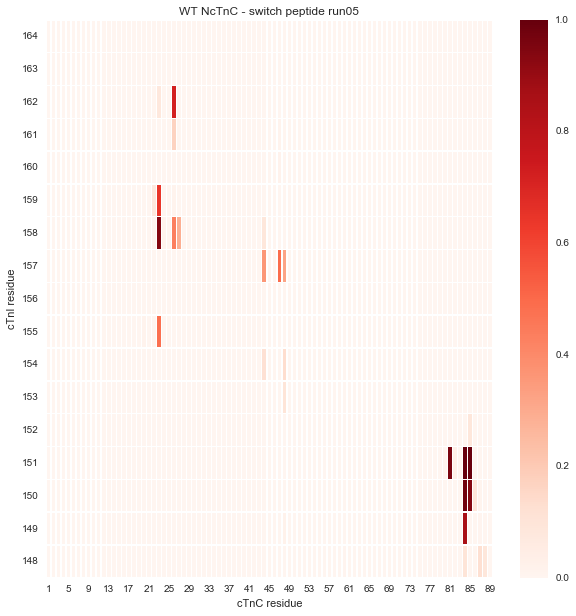

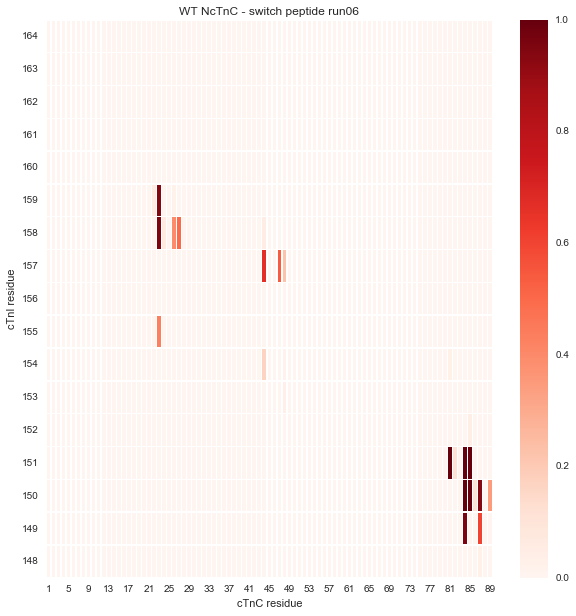

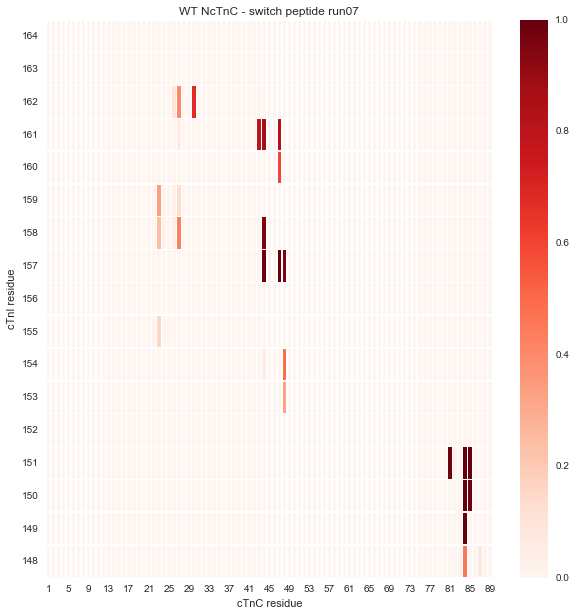

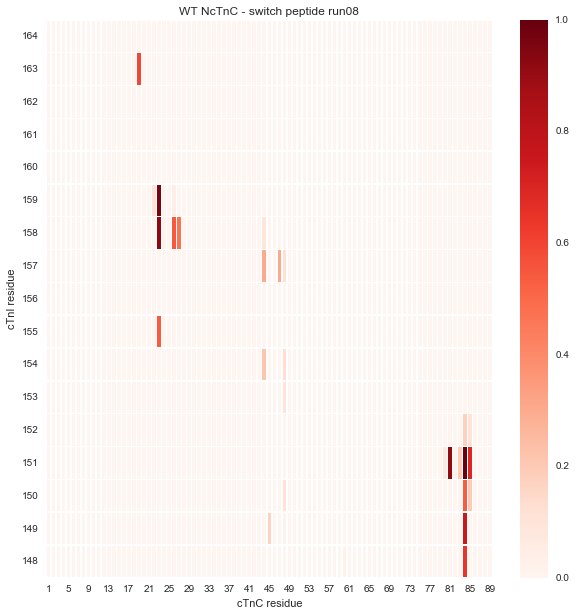

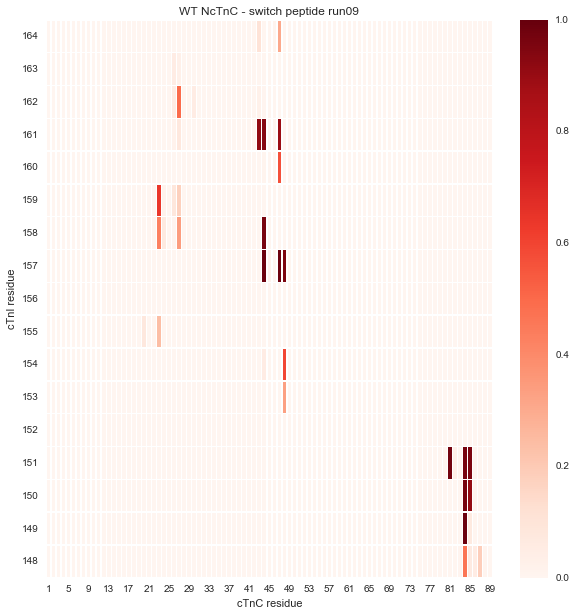

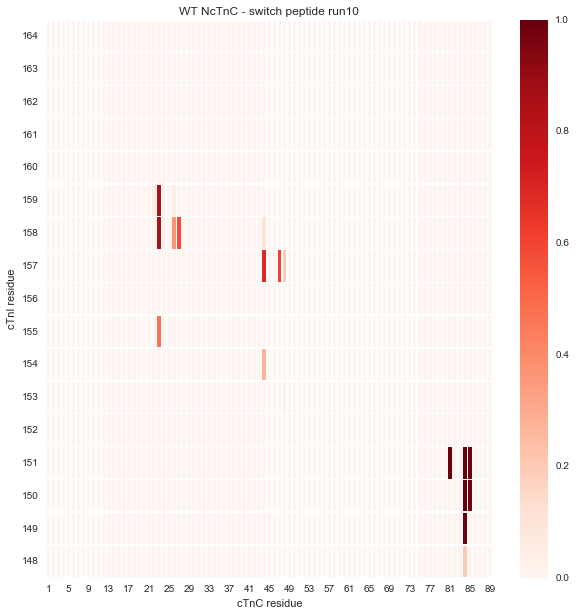

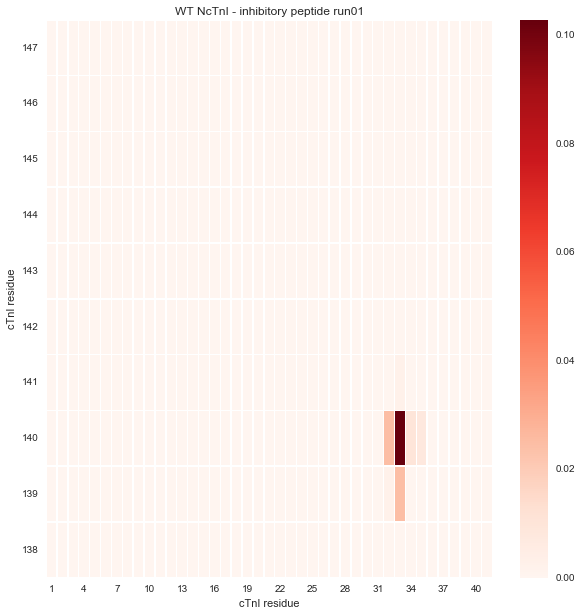

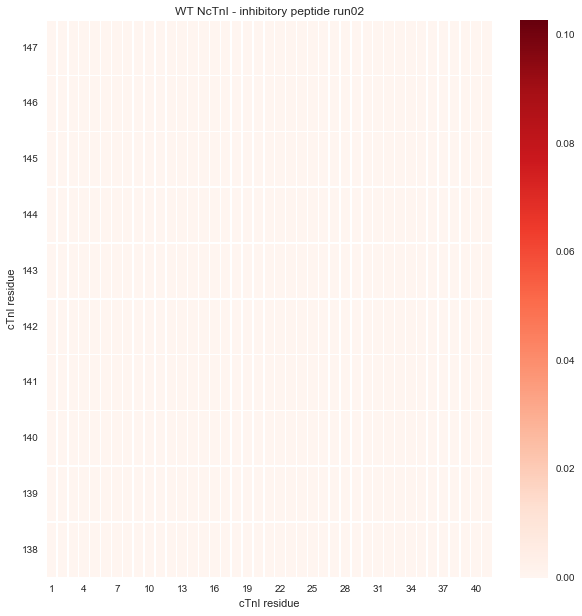

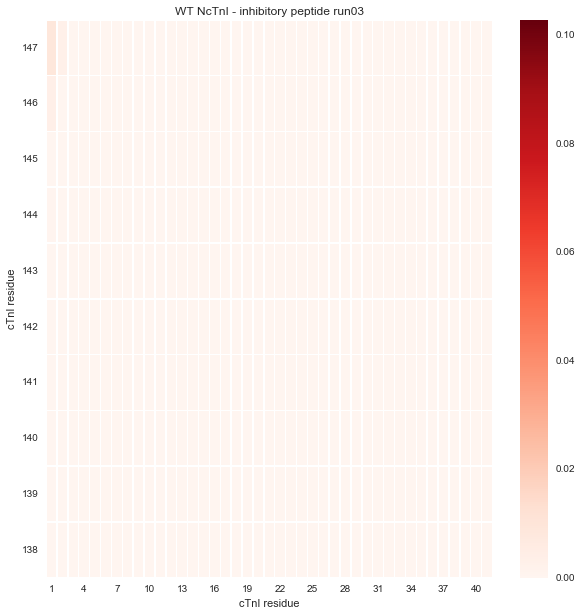

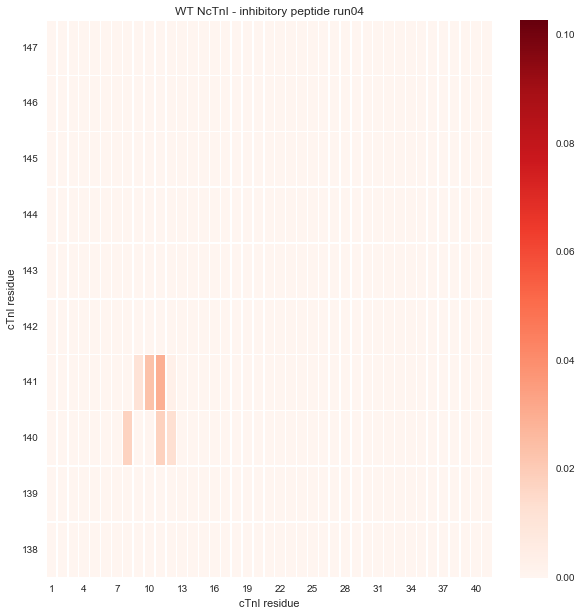

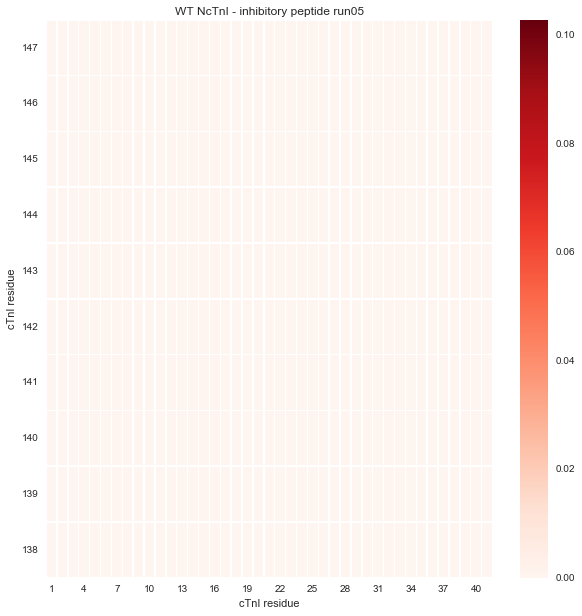

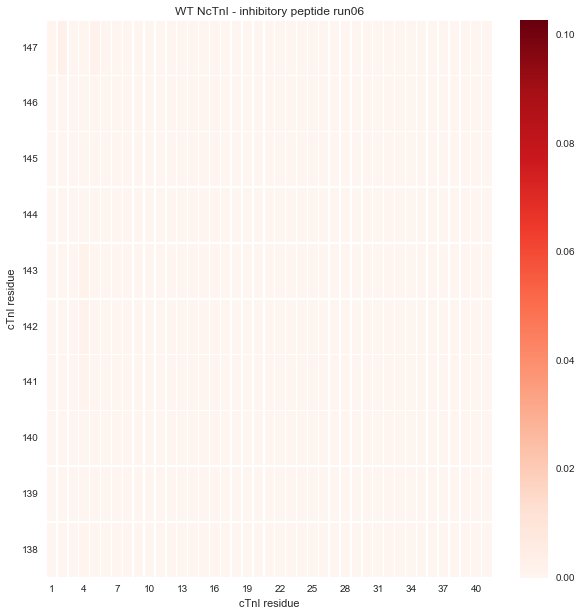

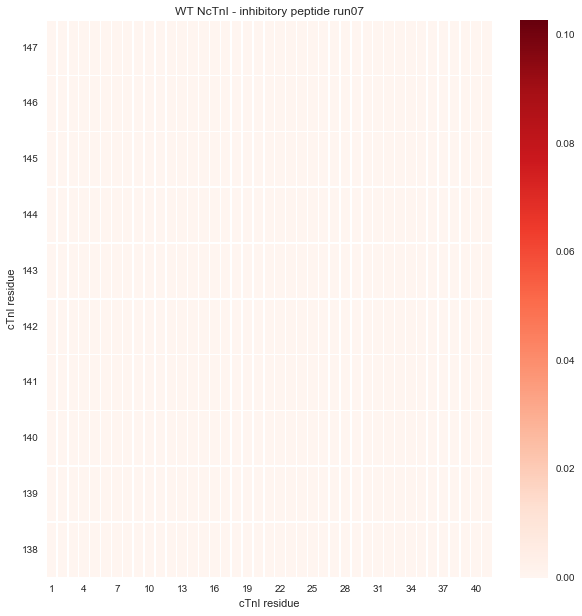

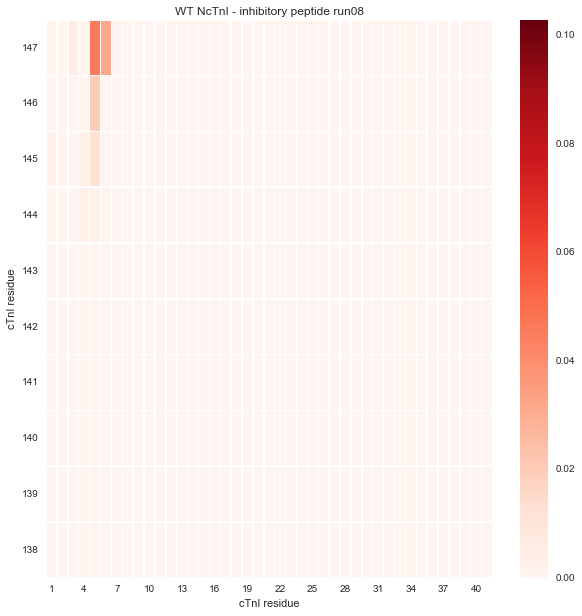

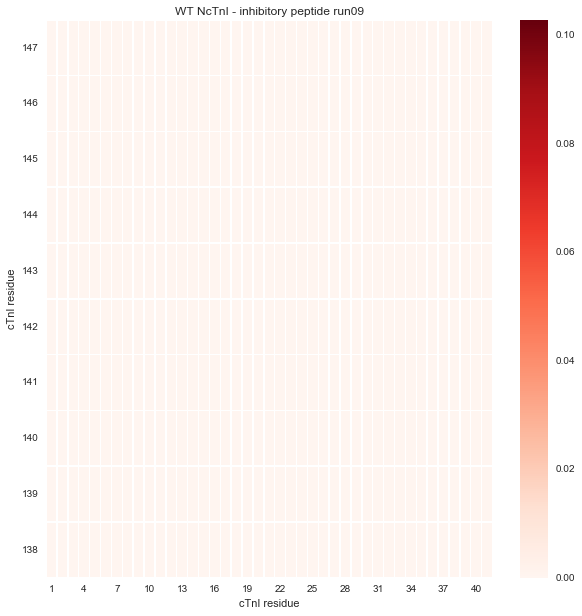

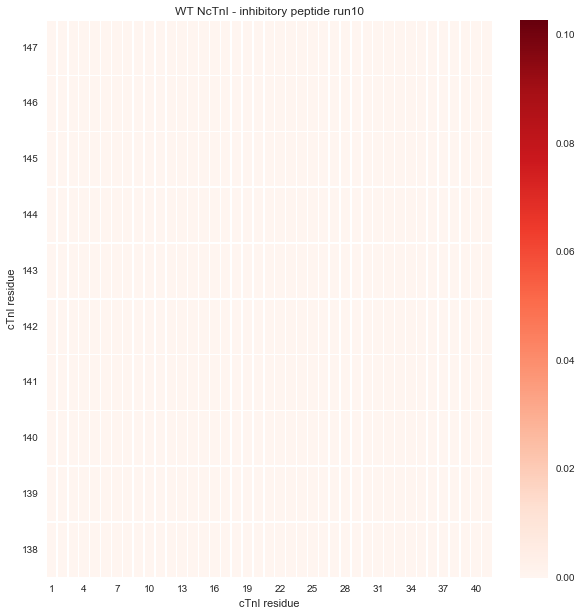

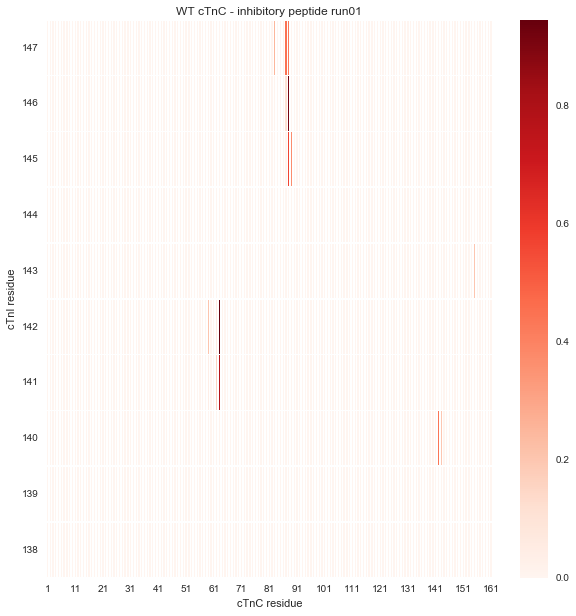

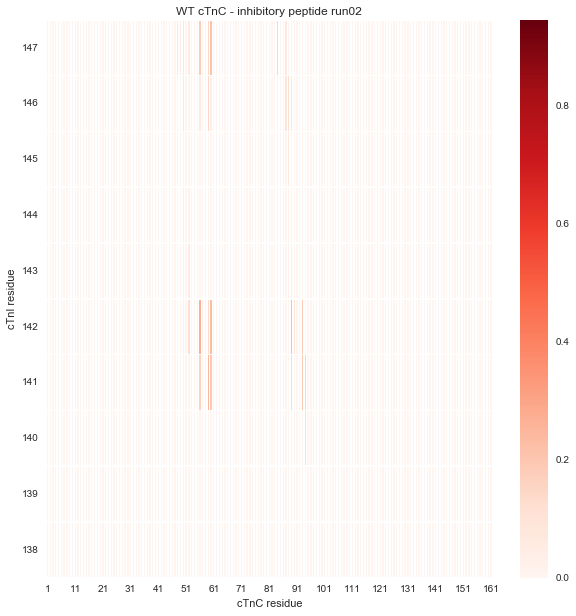

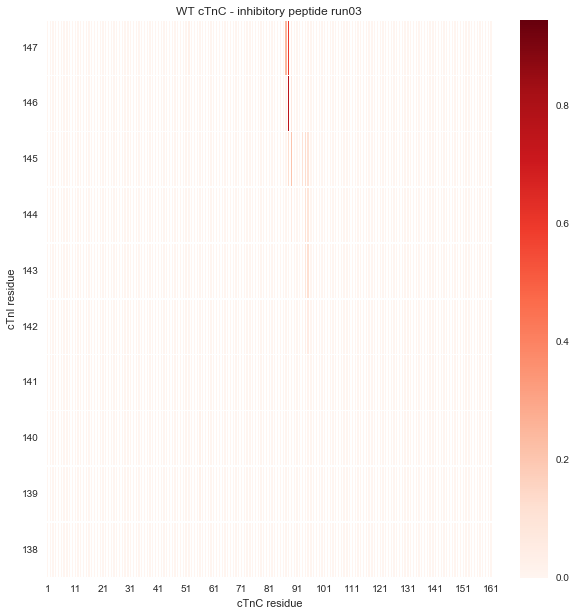

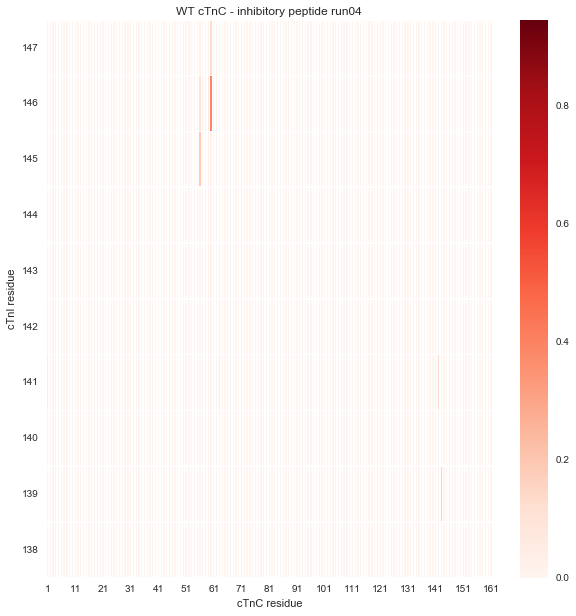

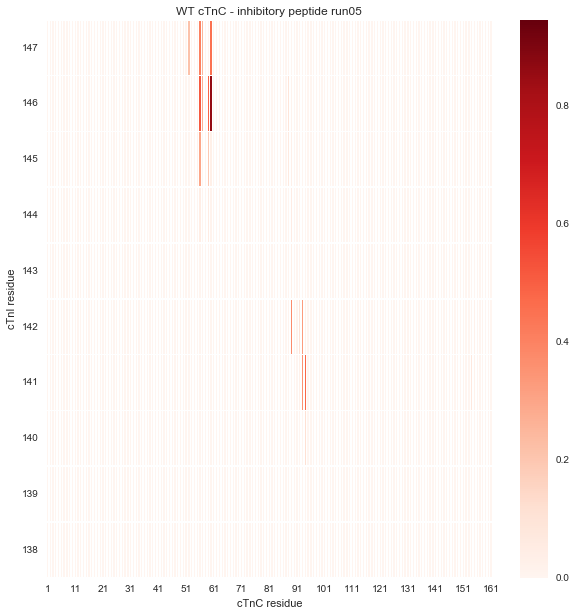

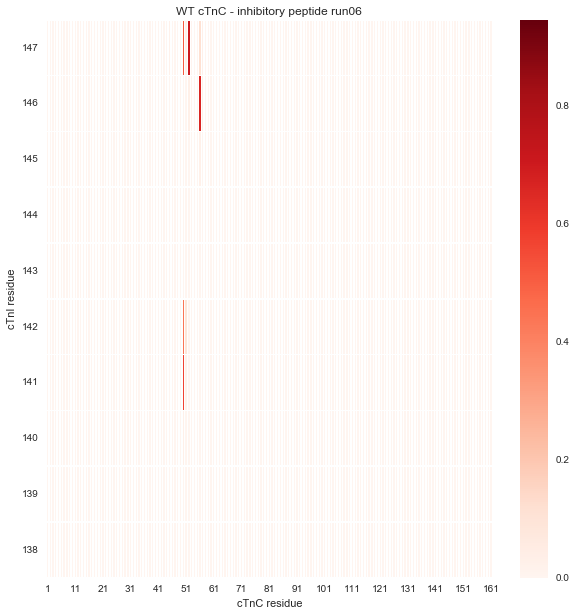

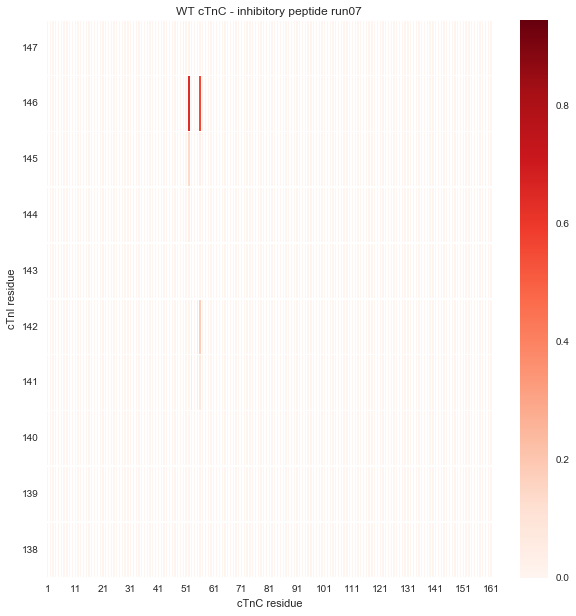

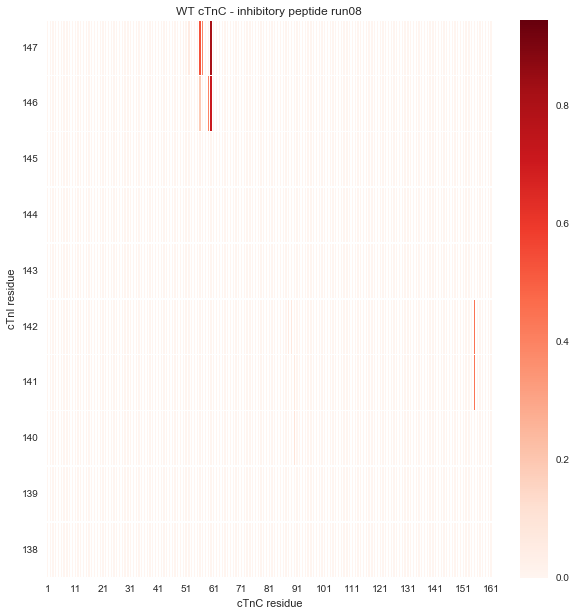

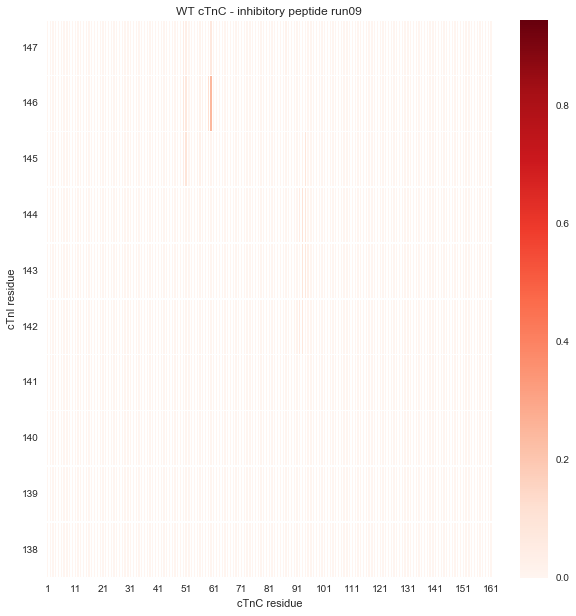

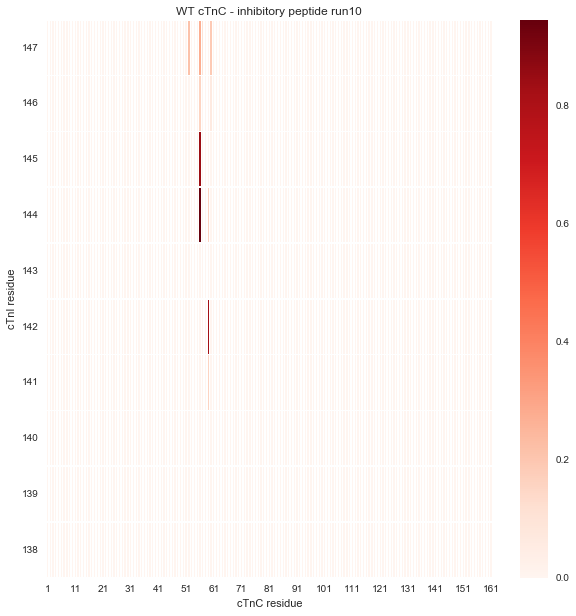

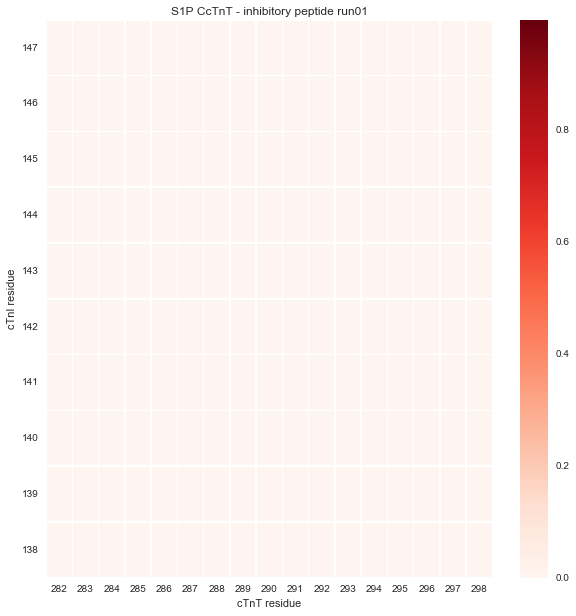

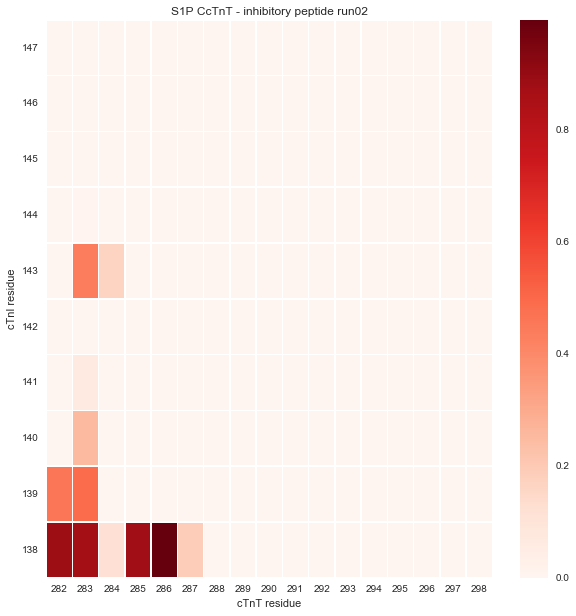

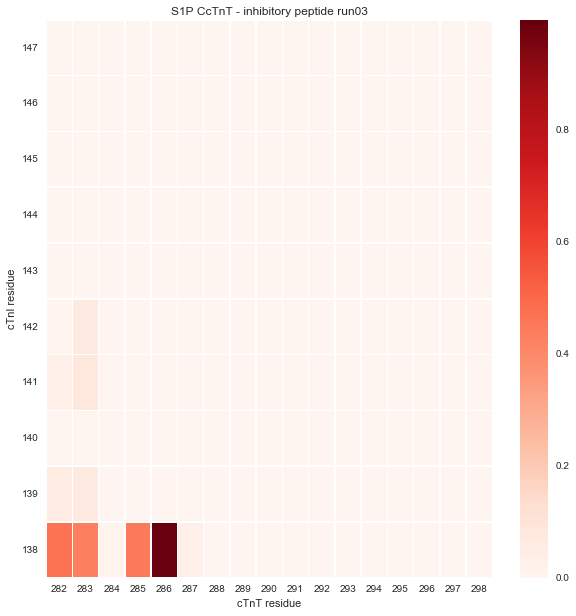

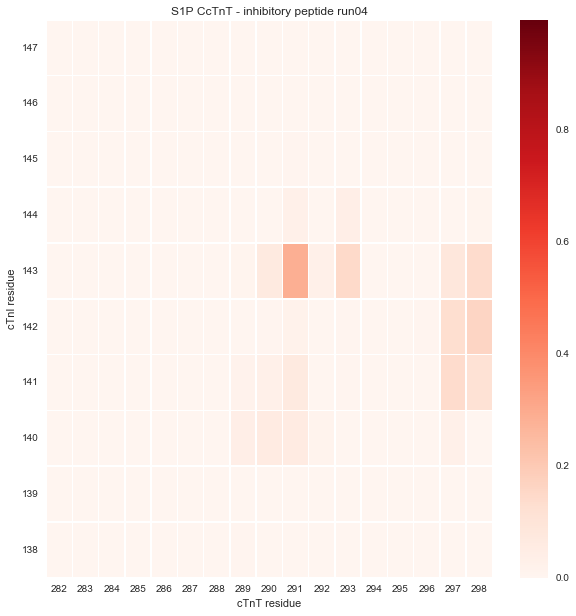

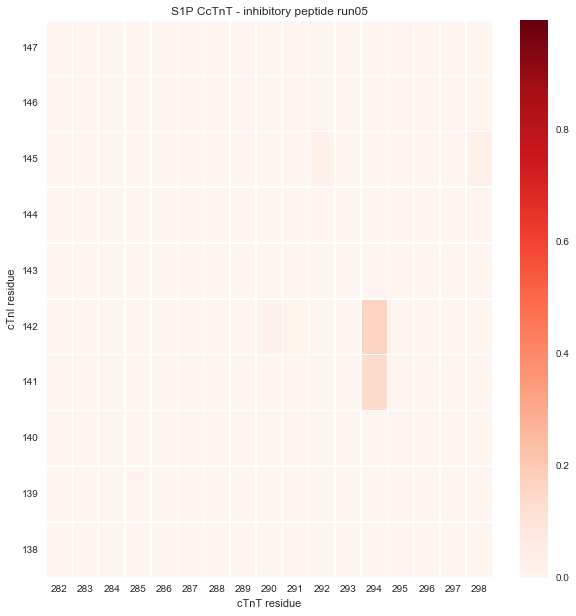

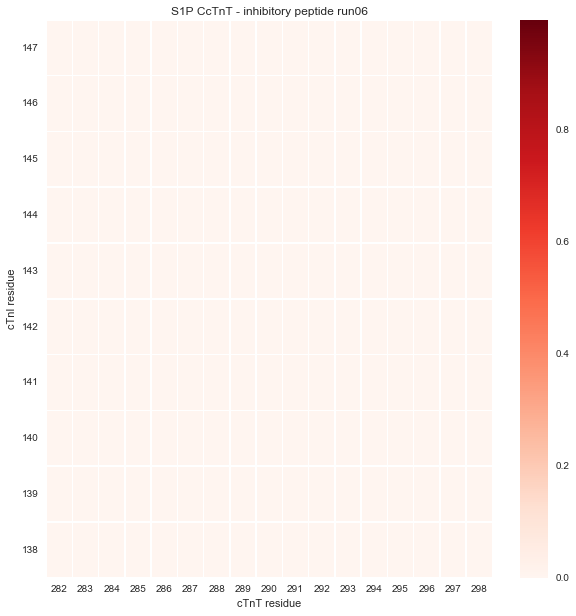

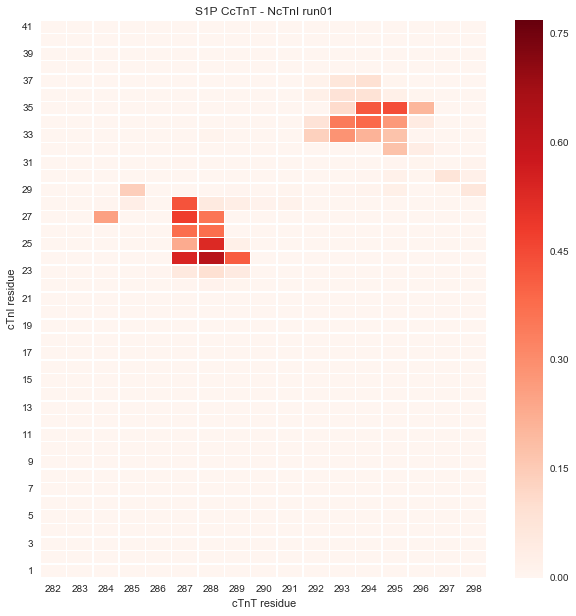

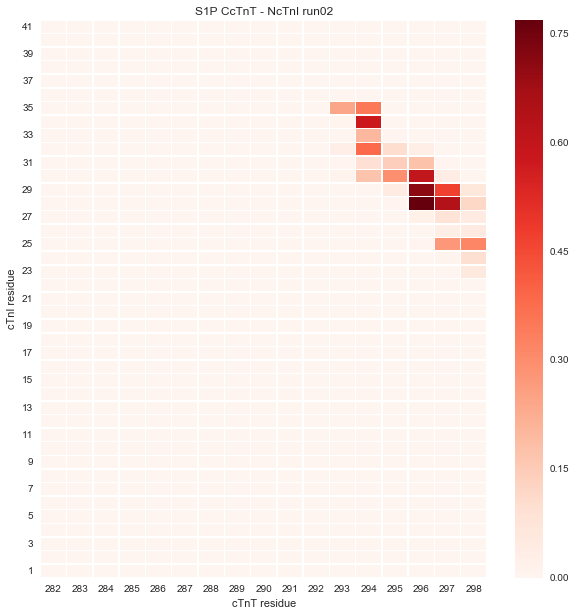

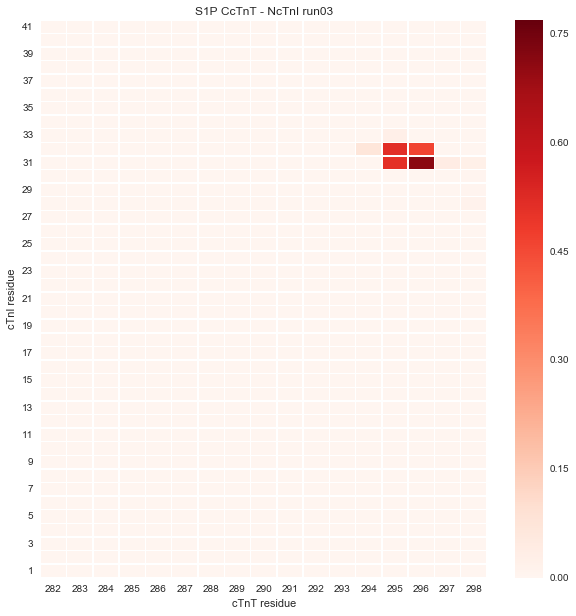

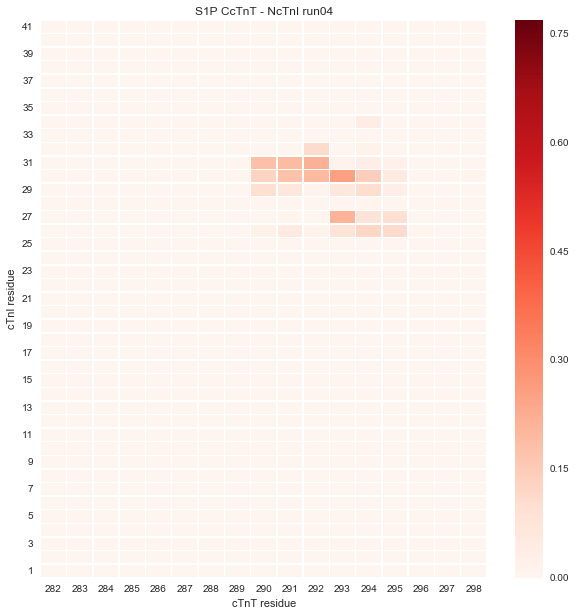

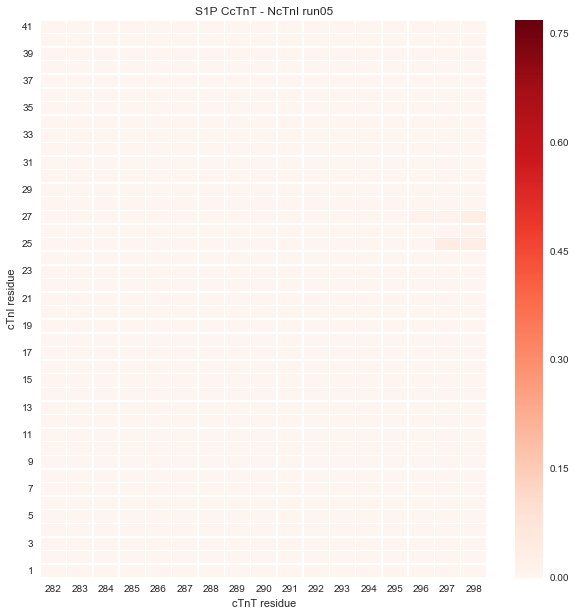

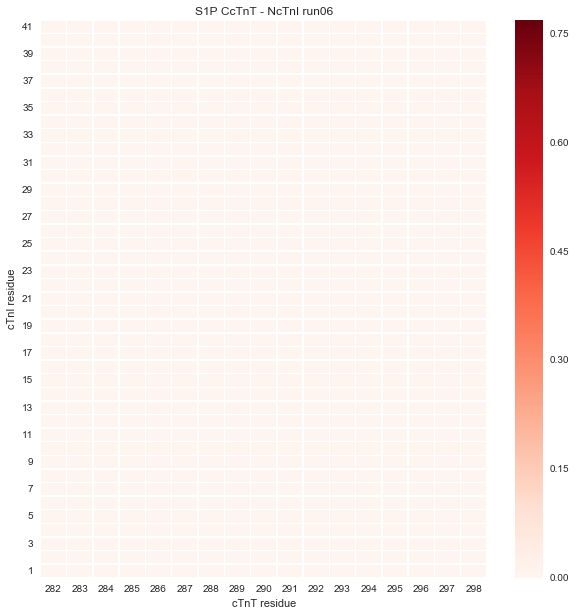

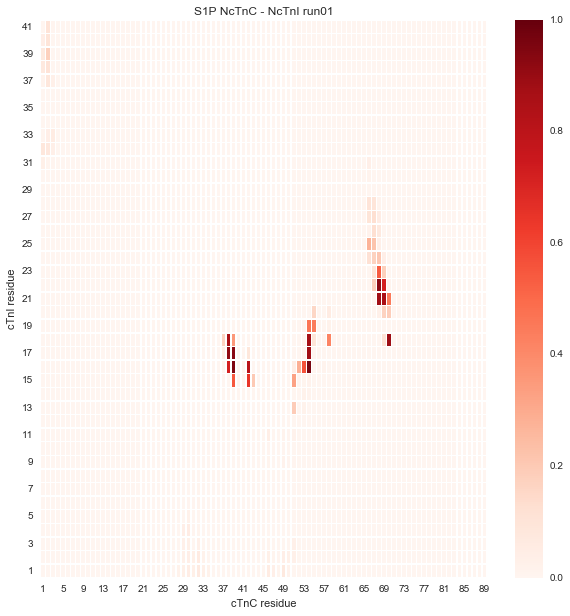

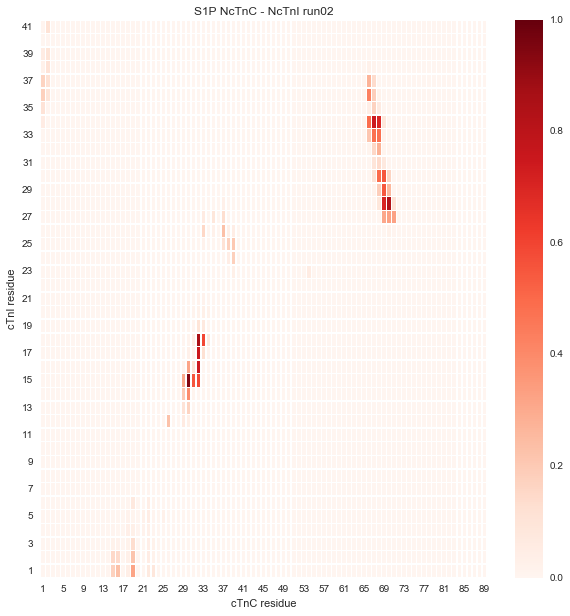

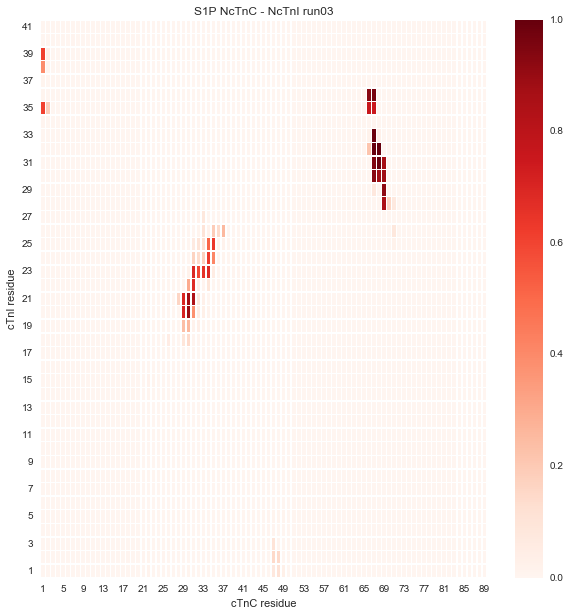

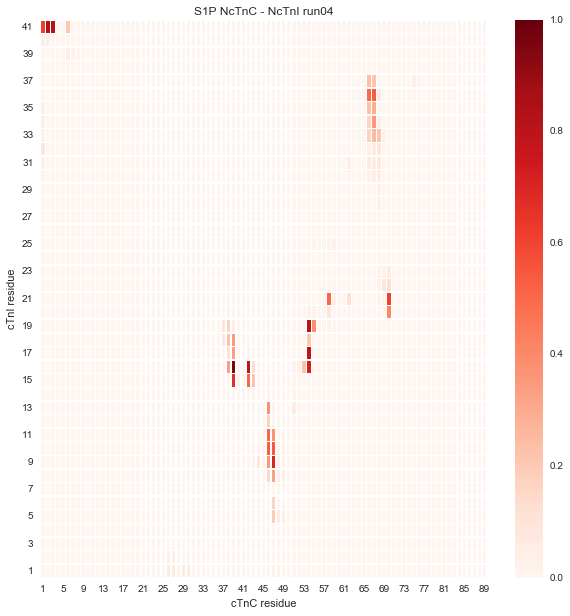

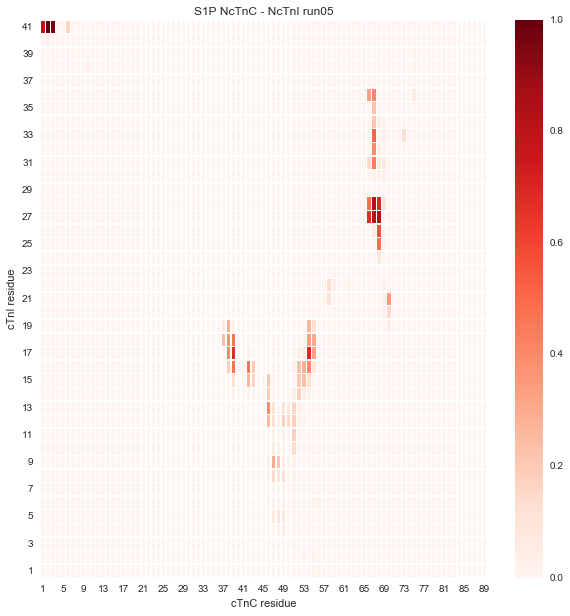

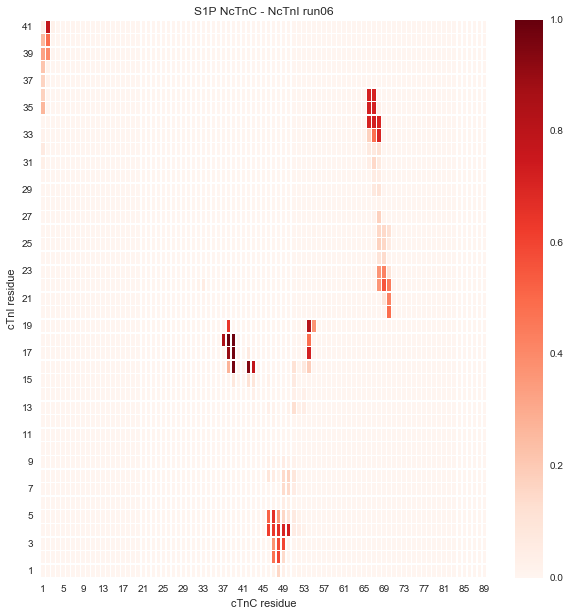

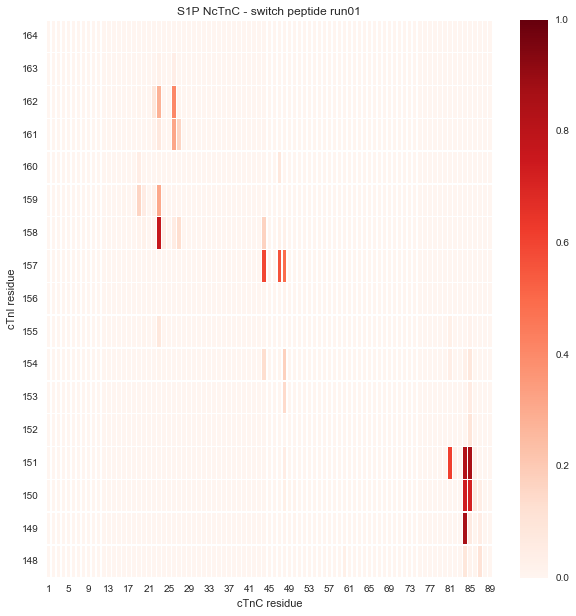

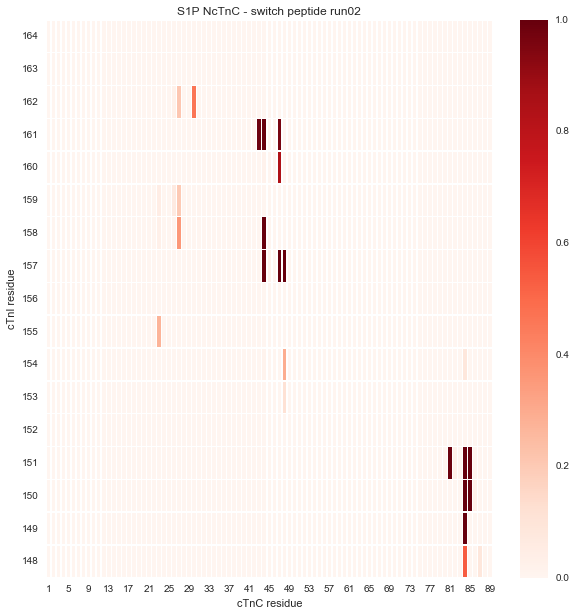

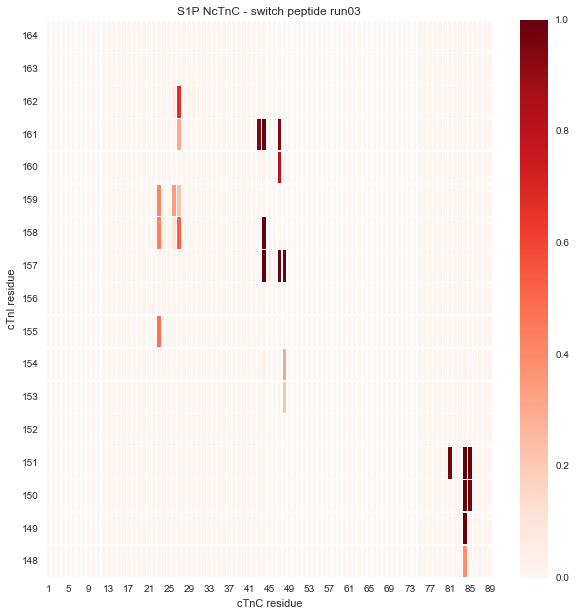

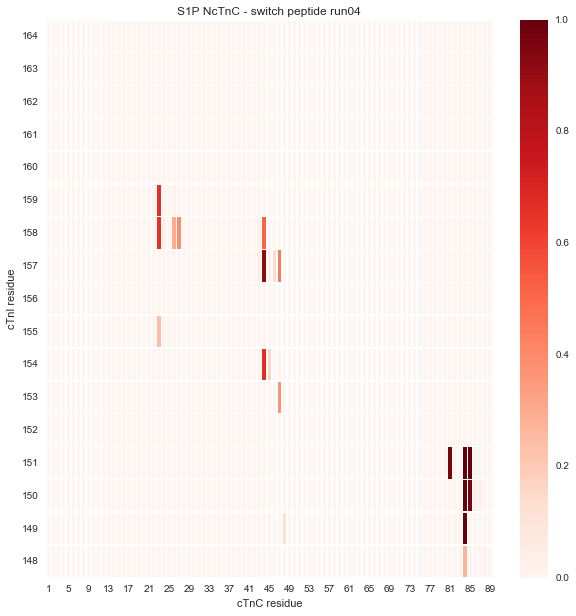

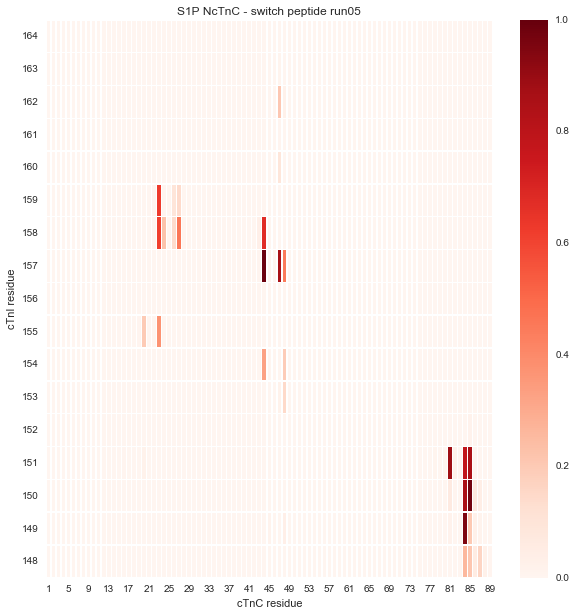

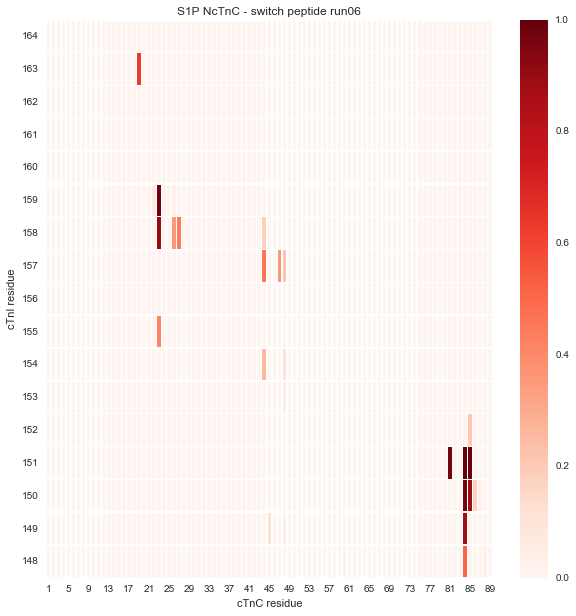

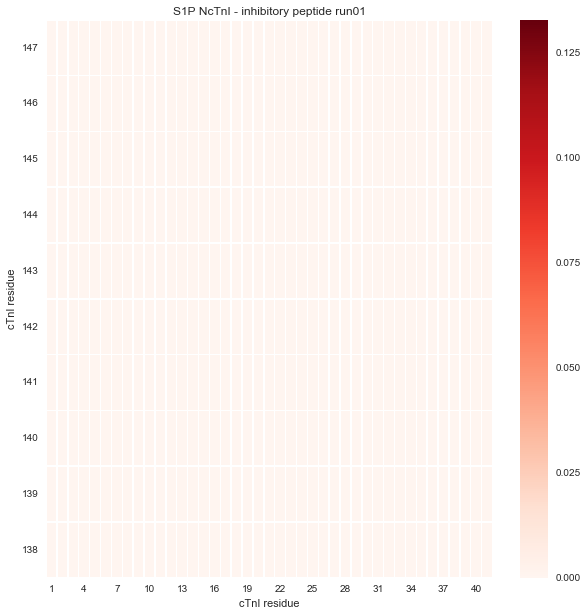

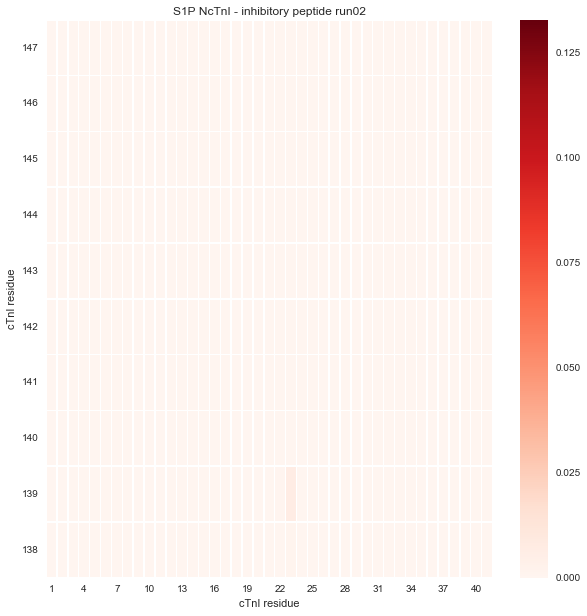

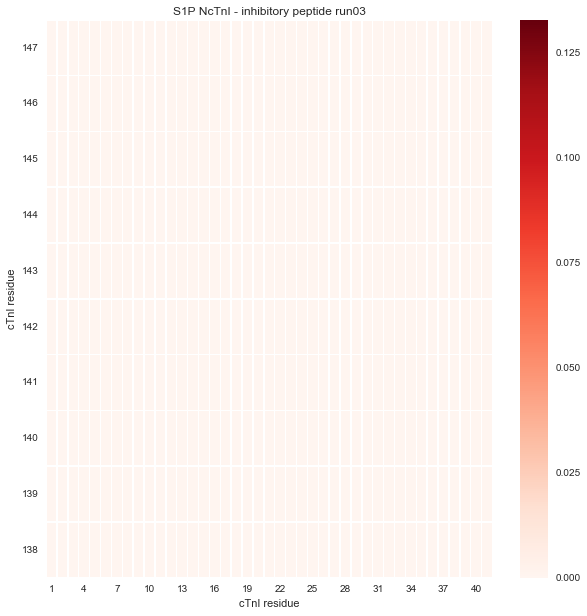

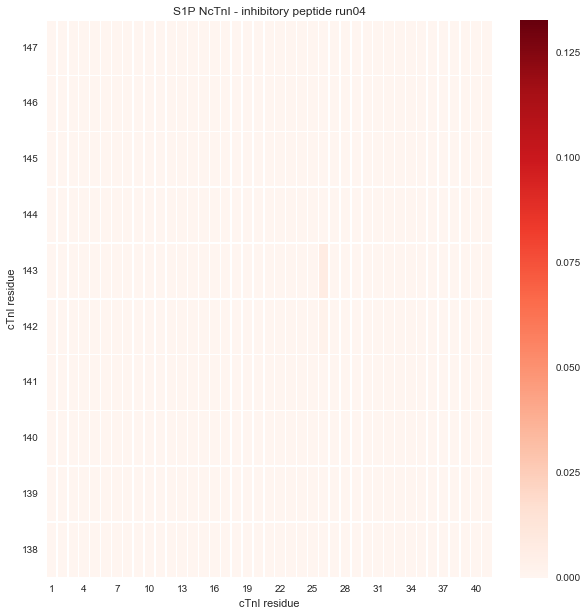

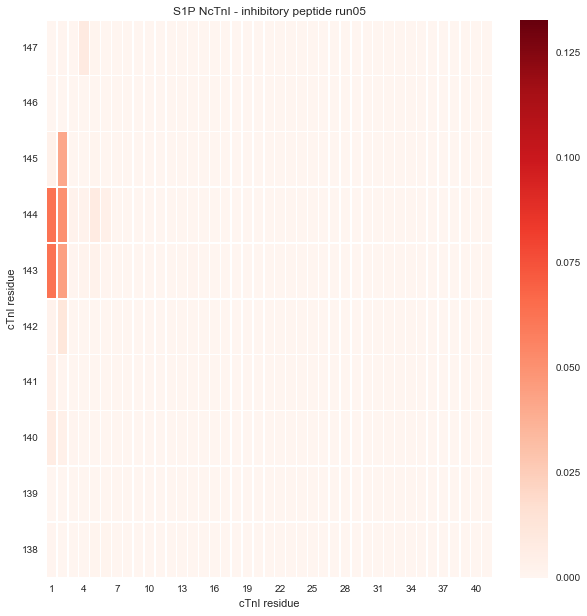

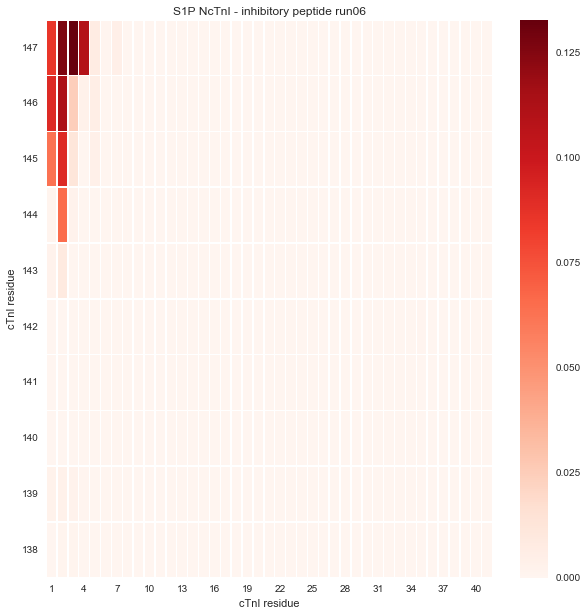

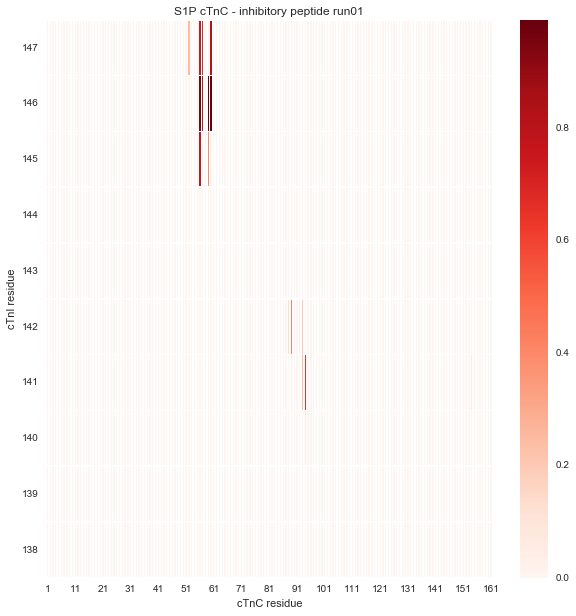

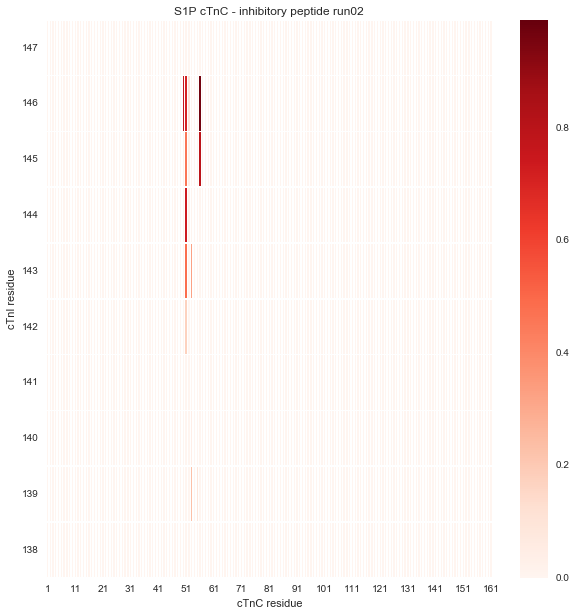

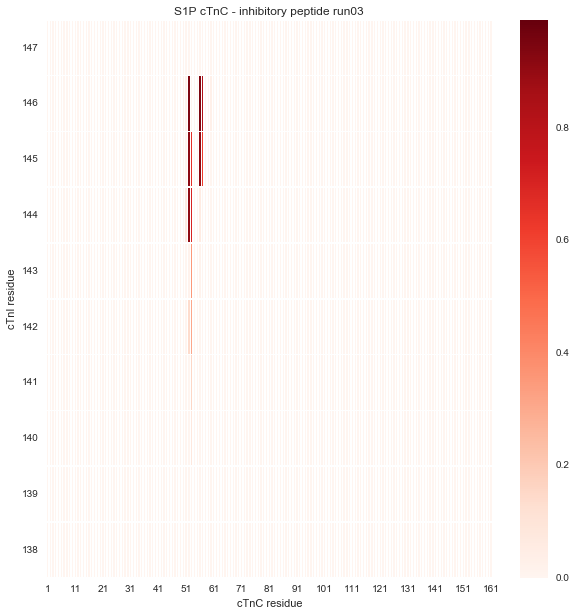

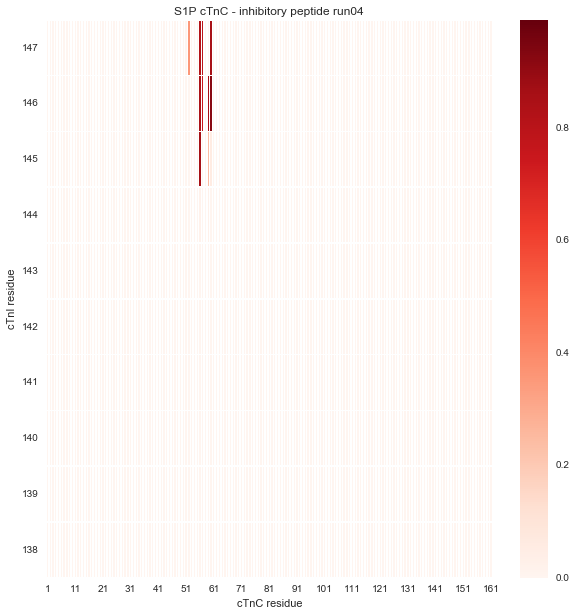

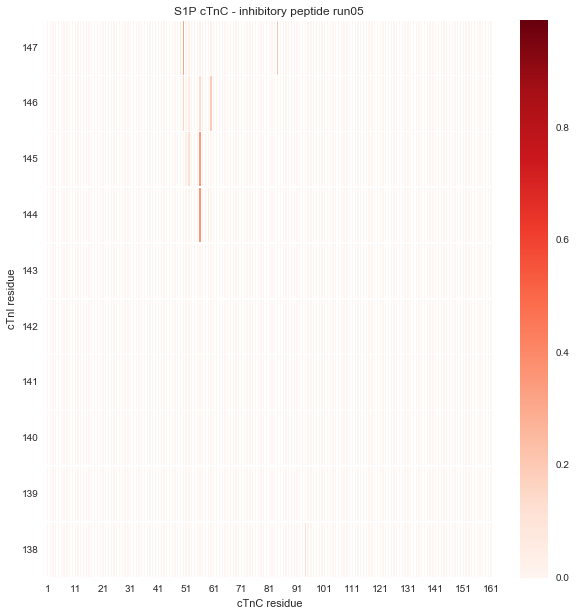

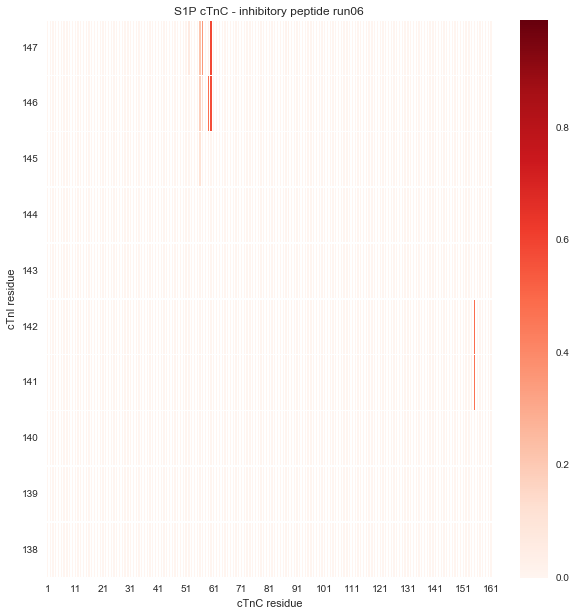

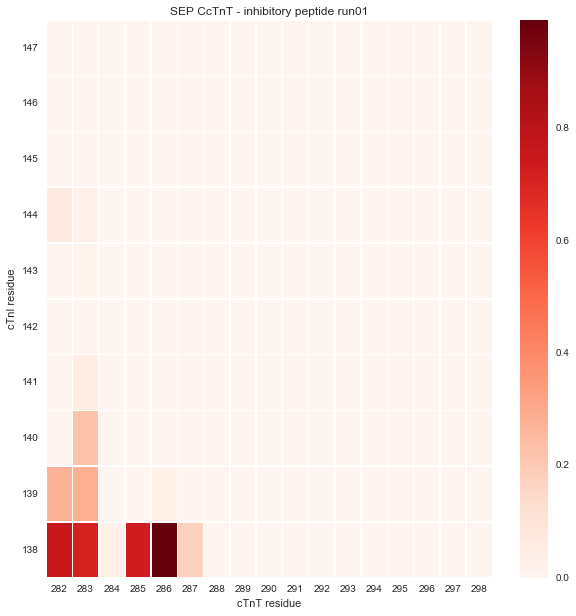

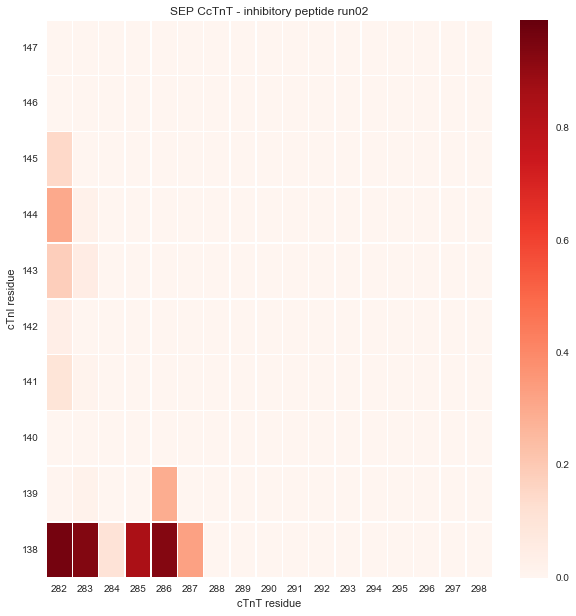

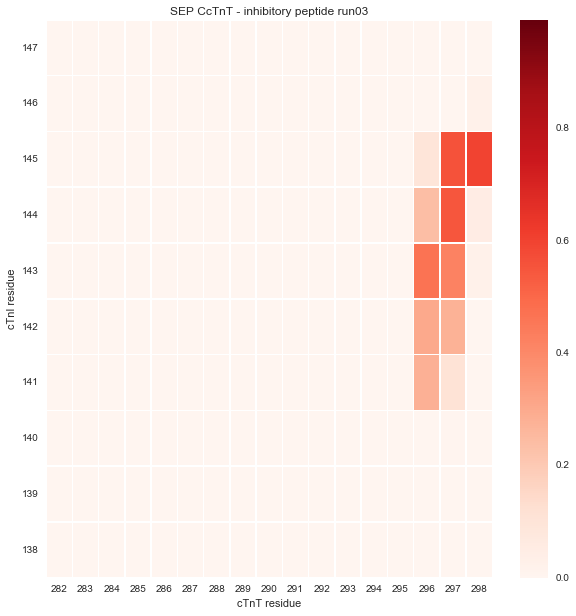

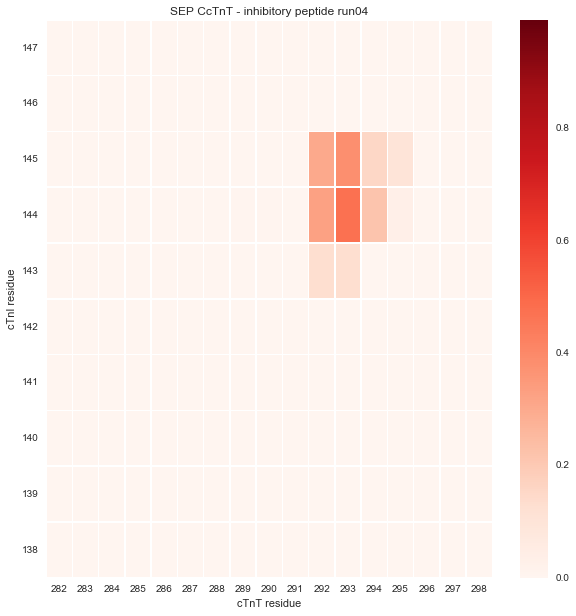

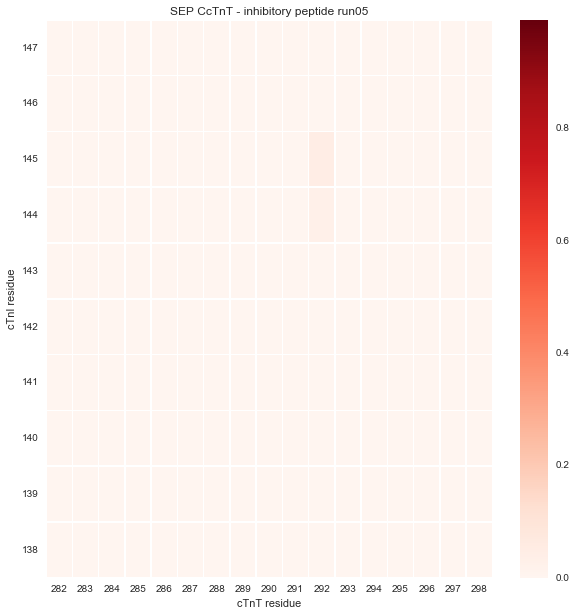

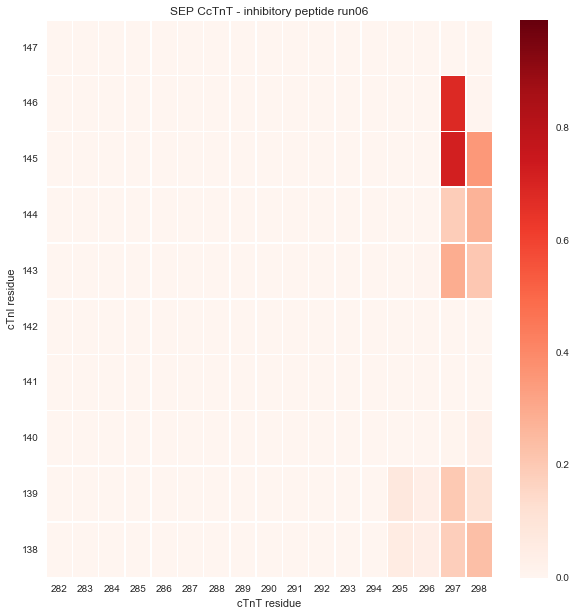

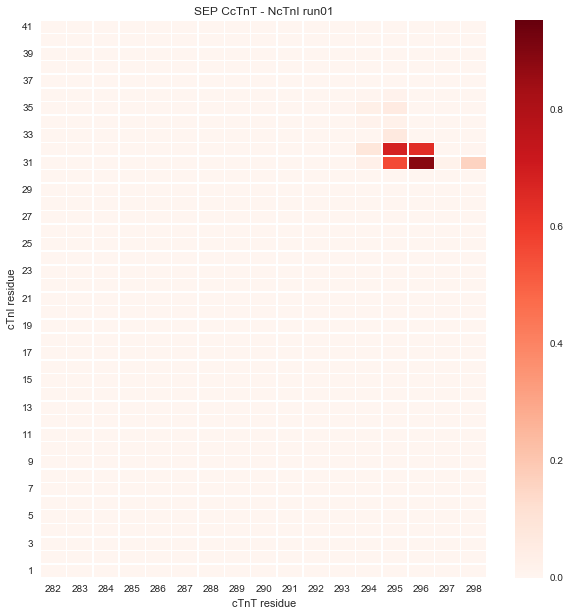

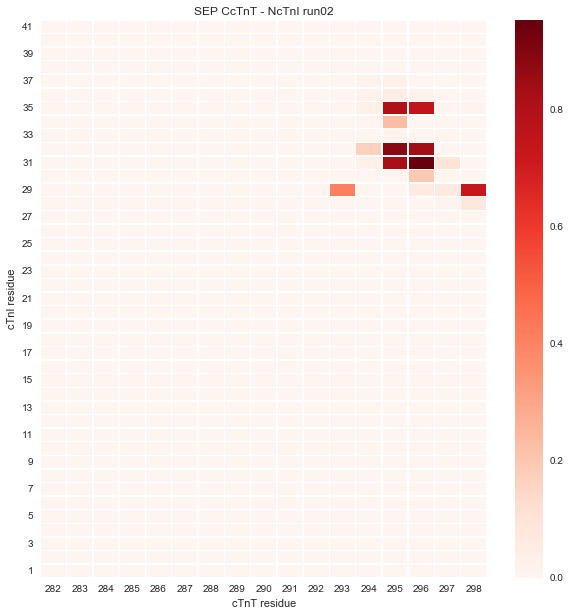

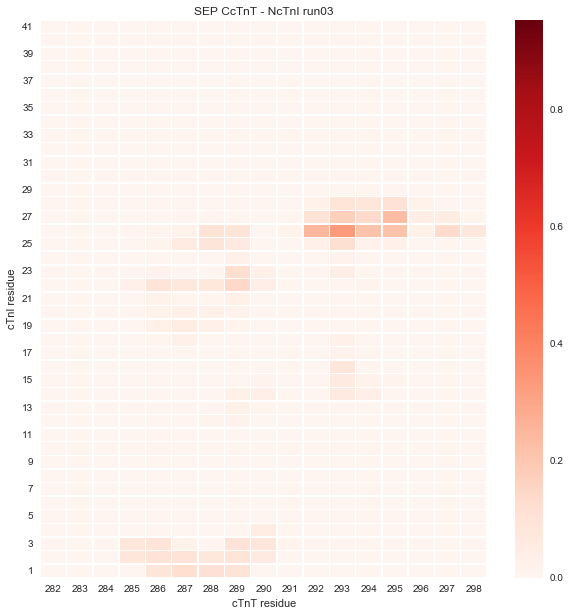

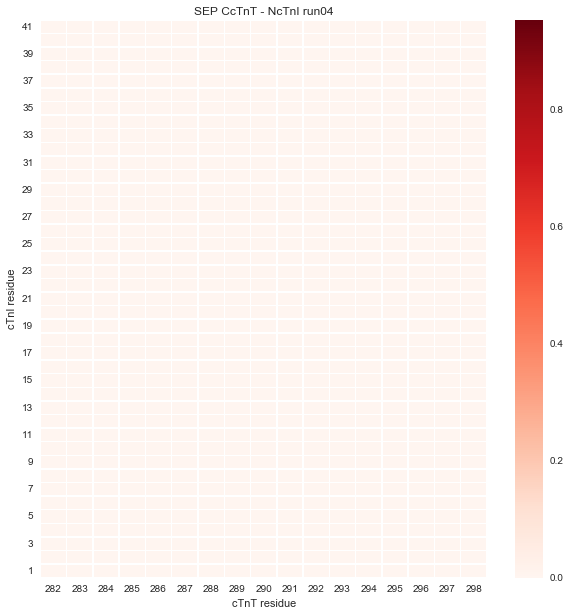

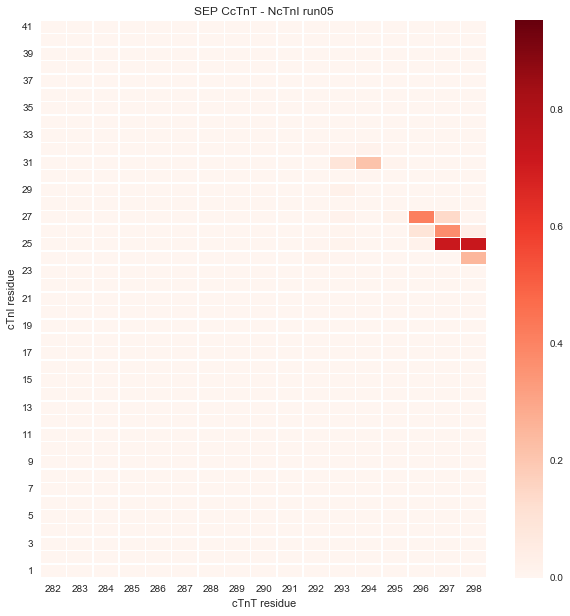

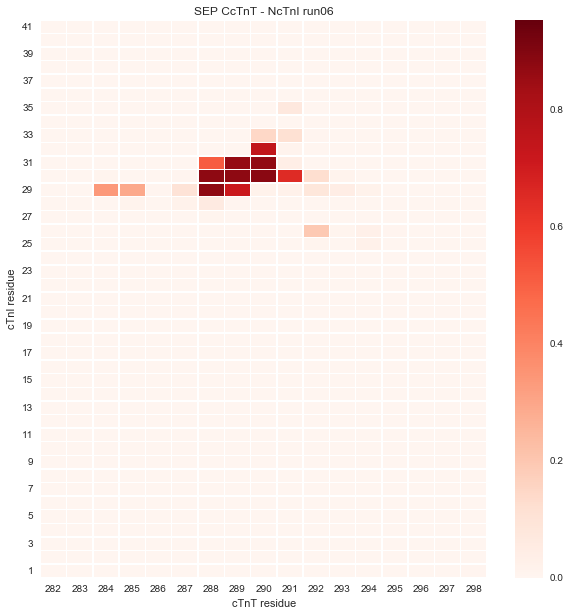

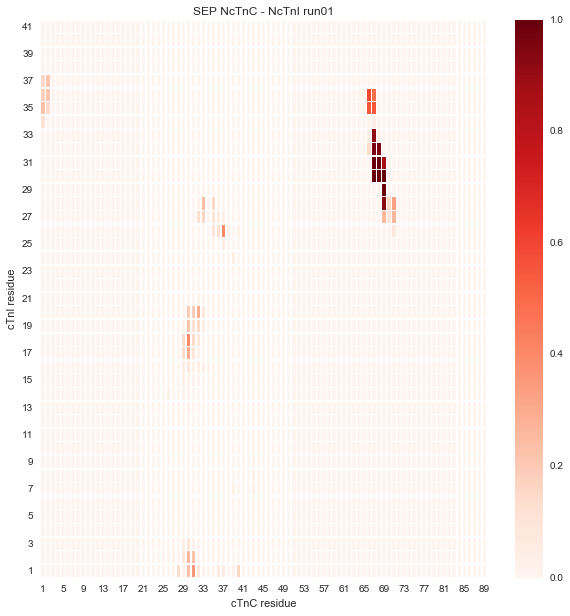

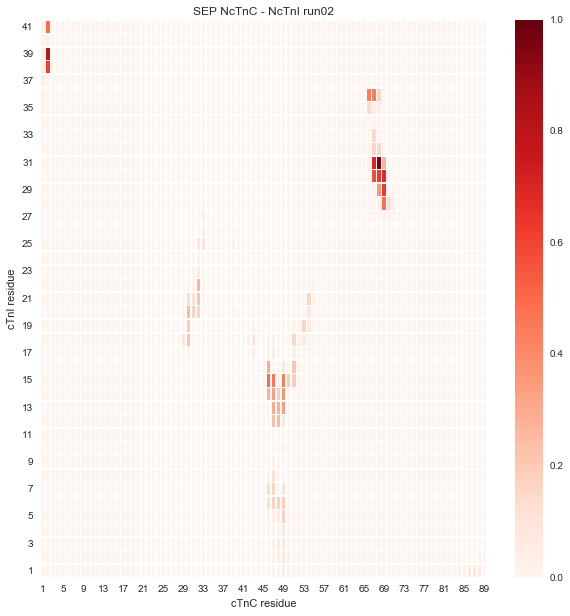

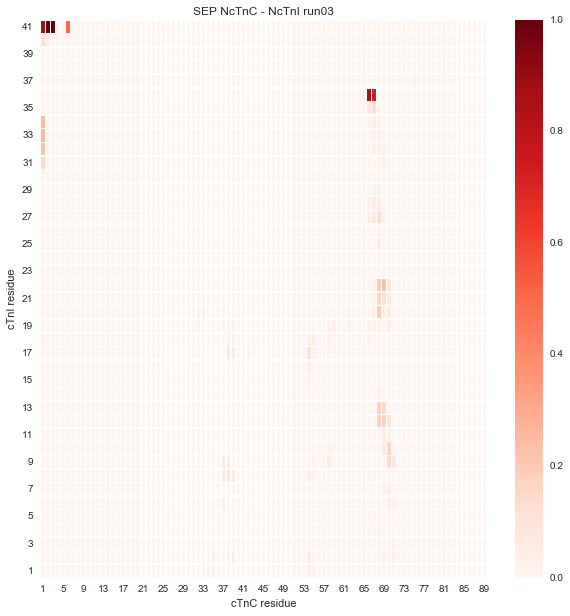

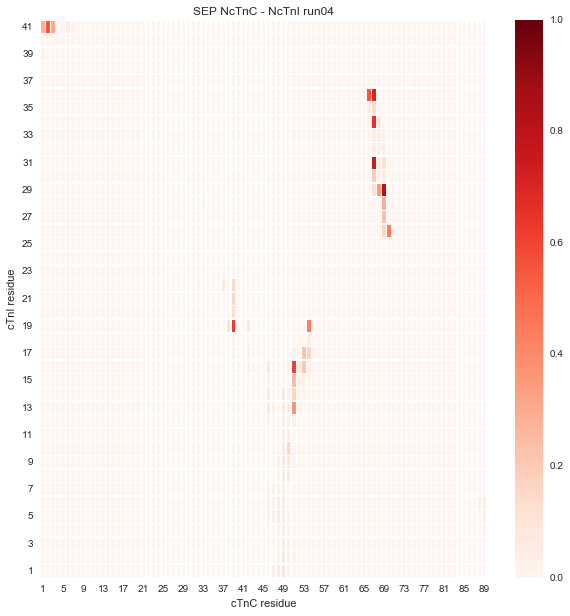

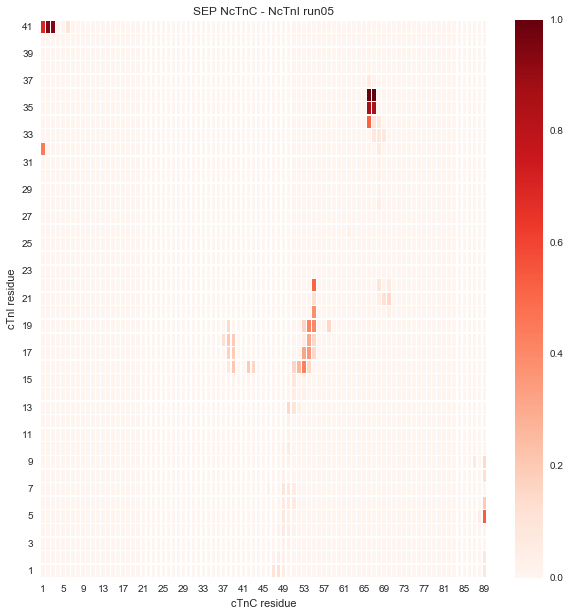

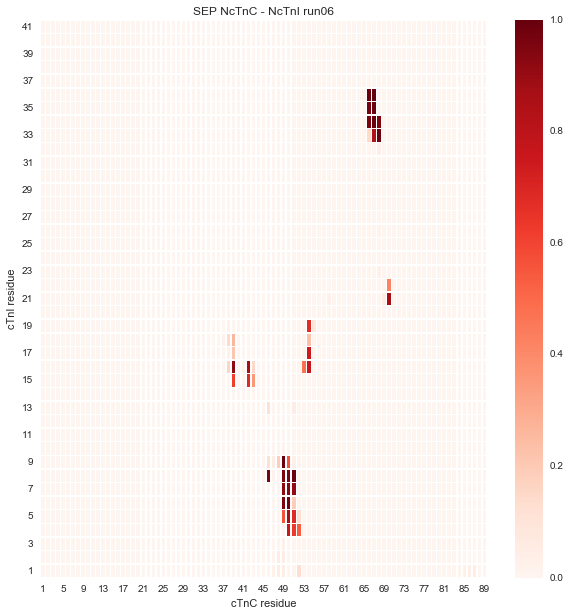

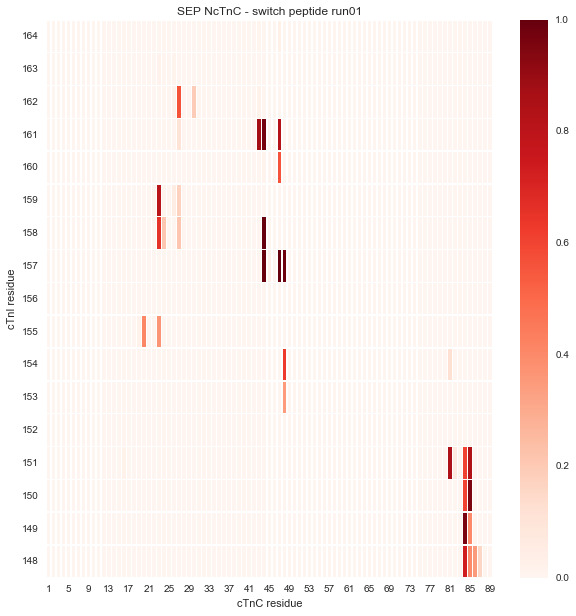

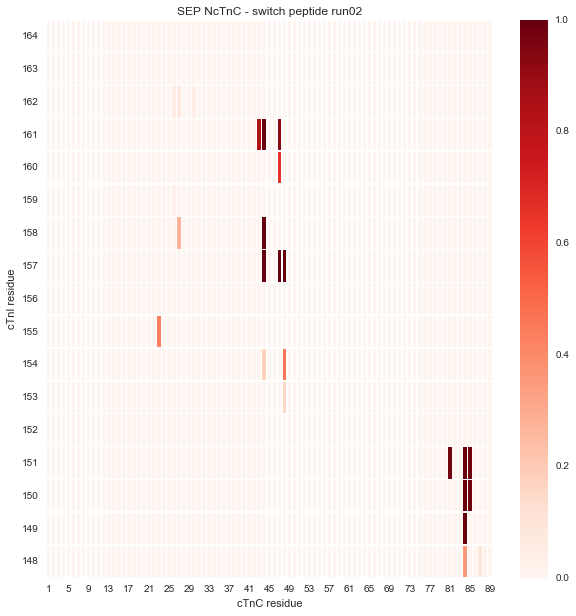

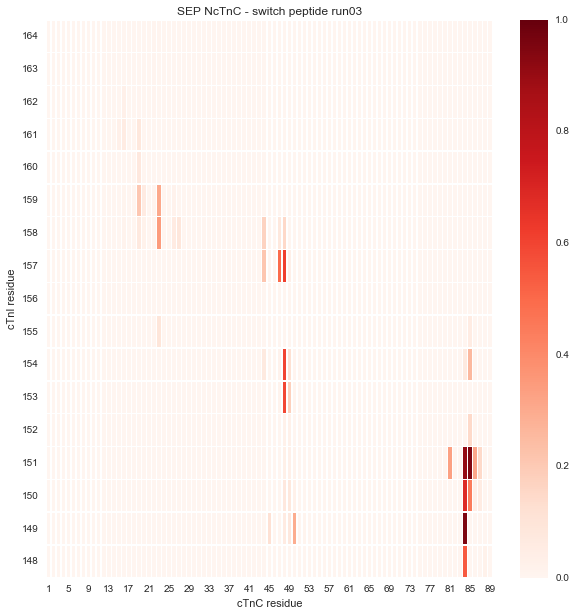

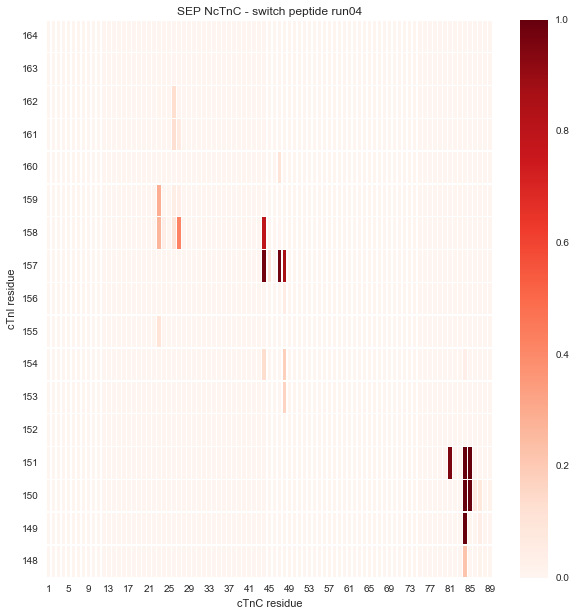

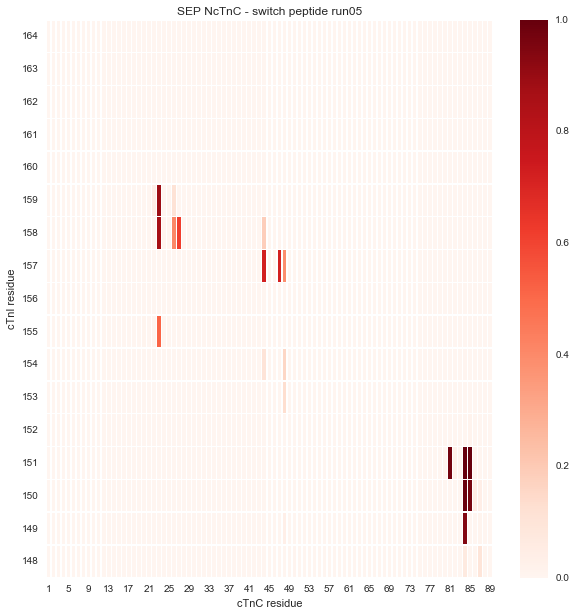

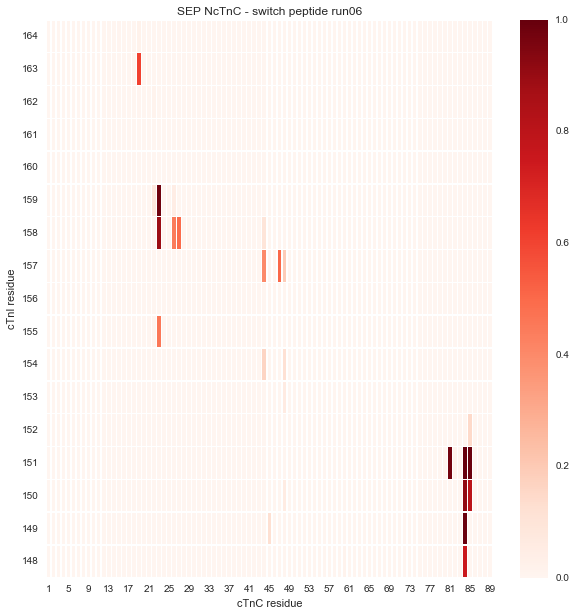

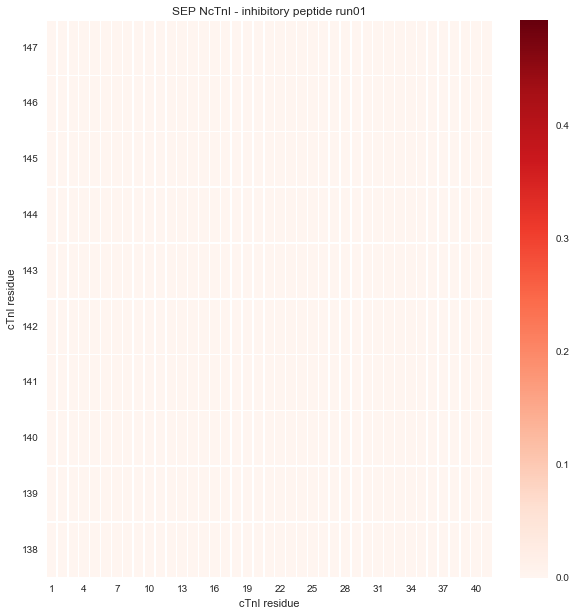

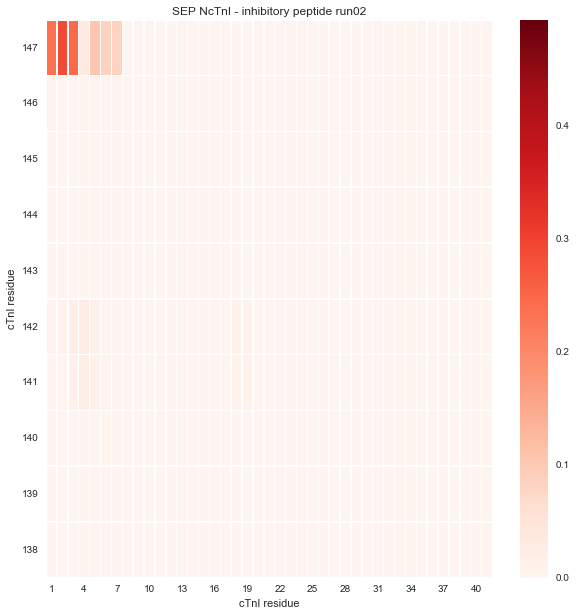

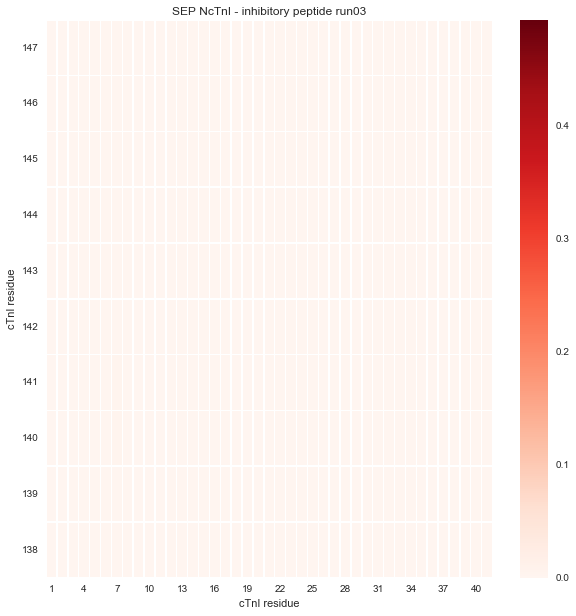

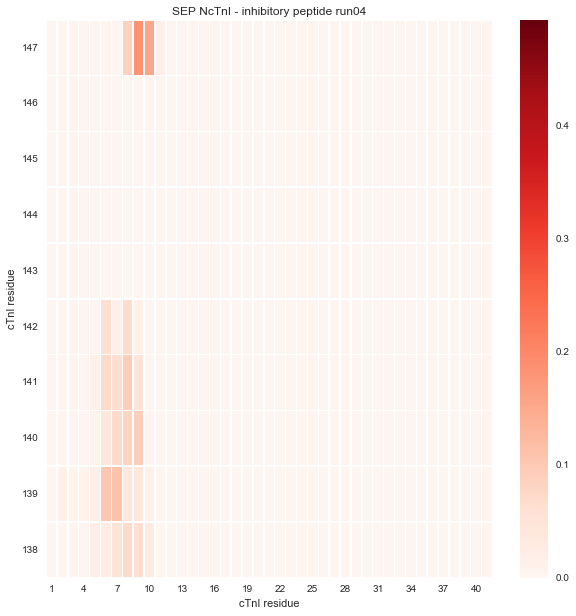

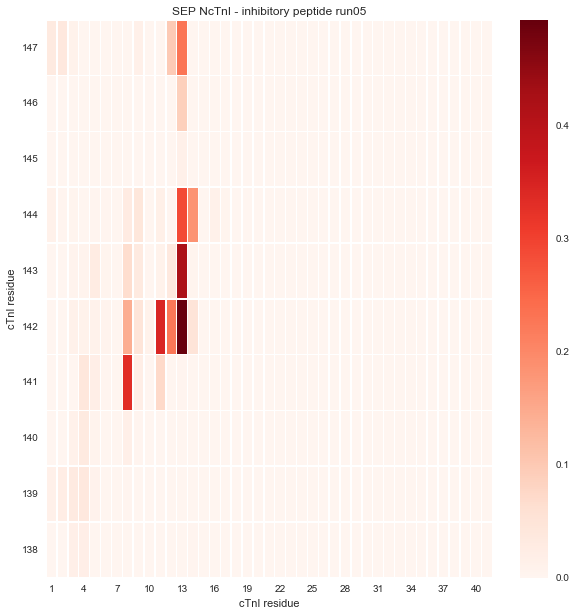

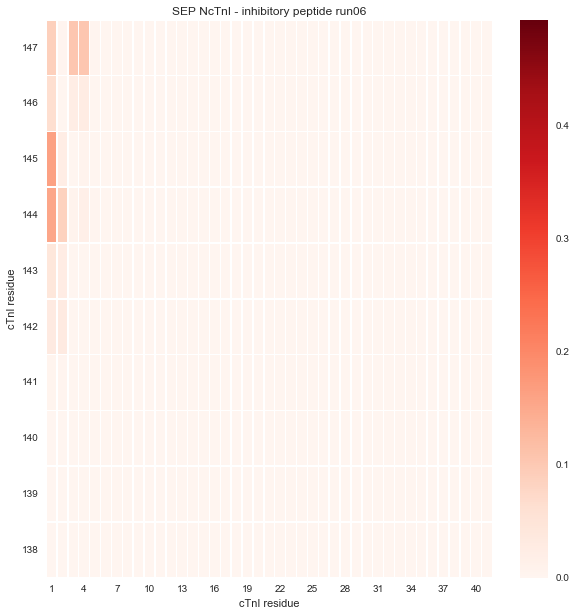

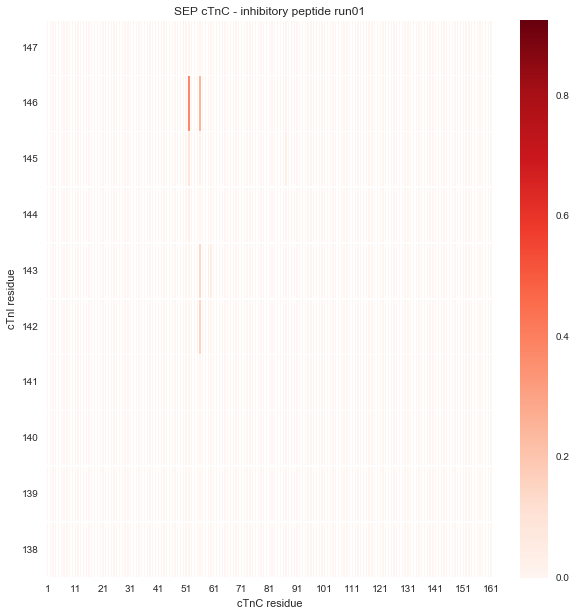

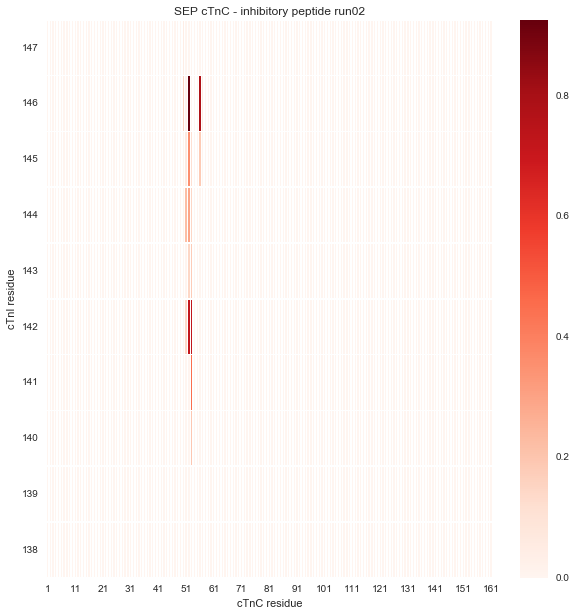

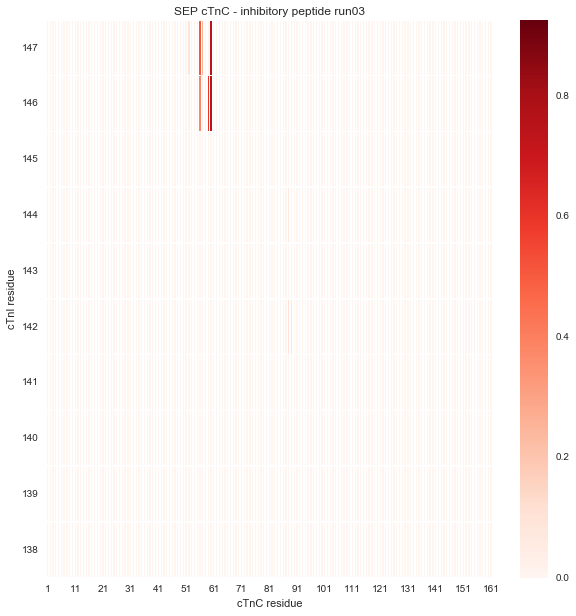

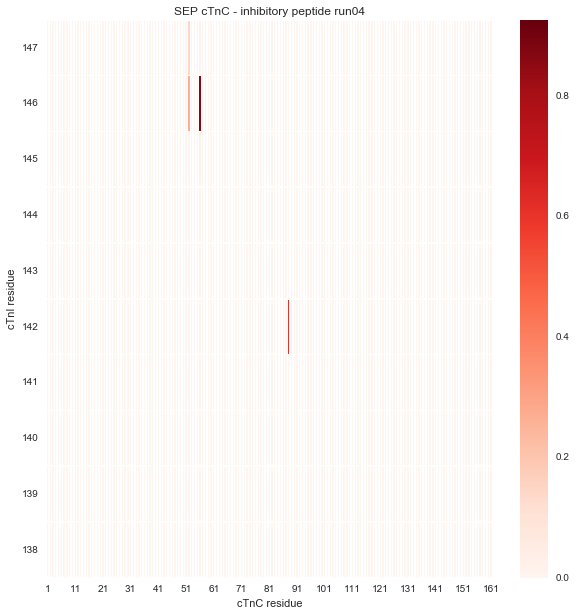

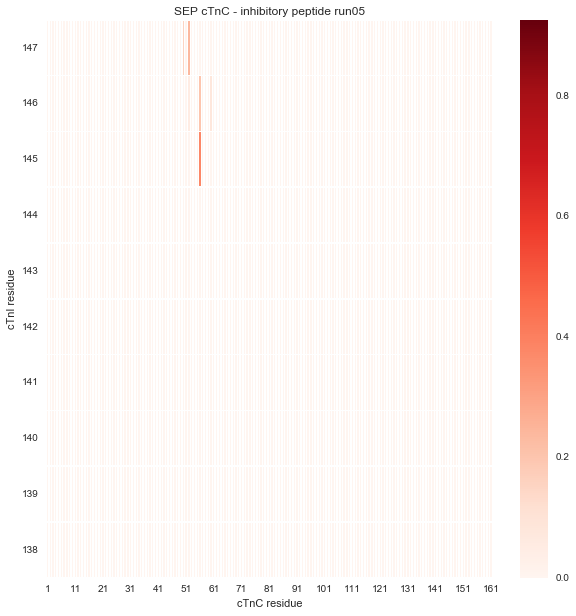

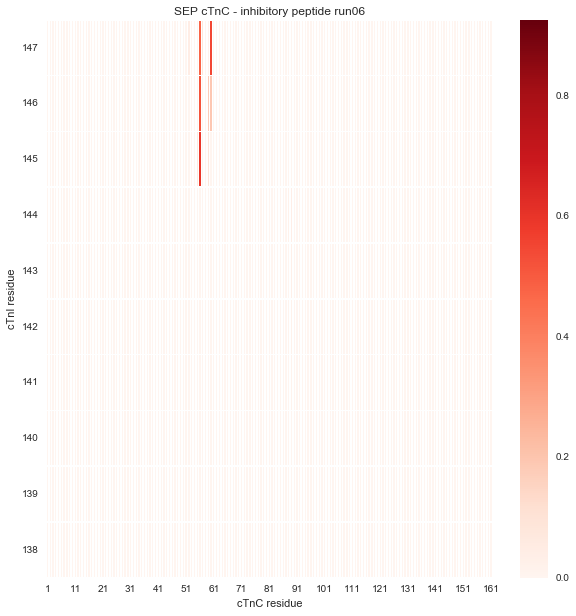

In [20]:
wt_split_maps = list(chunks(i_wt_cmaps, 10))
individual_plots(wt_split_maps, region_list, system="WT")
s1p_split_maps = list(chunks(i_s1p_cmaps, 6))
individual_plots(s1p_split_maps, region_list, system="S1P")
sep_split_maps = list(chunks(i_sep_cmaps, 6))
individual_plots(sep_split_maps, region_list, system="SEP")

In [ ]:
def getError_diffPlot(wt_maps_list, s1p_maps_list, sep_maps_list):
    """
    Use the uncertainties package to calculate the error
    propagation in the operations (averaging of the 
    two types of phosphorylated systems, and the substraction
    to get the difference plot.)
    """
    WT = np.dstack(wt_maps_list)
    S1P = np.dstack(s1p_maps_list)
    SEP = np.dstack(sep_maps_list)
    
    WT_uarray = unumpy.uarray((WT.mean(2), WT.std(2)))
    S1P_uarray = unumpy.uarray((S1P.mean(2), S1P.std(2)))
    SEP_uarray = unumpy.uarray((SEP.mean(2), SEP.std(2)))

    diff_uarray = ((S1P_uarray + SEP_uarray) / 2) - WT_uarray

    diff_val = unumpy.nominal_values(diff_uarray)
    diff_std = unumpy.std_devs(diff_uarray)

    return(diff_val, diff_std)

In [ ]:
for wt_maps, s1p_maps, sep_maps, region in zip(wt_split_maps, s1p_split_maps, sep_split_maps, region_list):
    diff_val, diff_std = getError_diffPlot(wt_maps, s1p_maps, sep_maps)
    y_step, x_step, y_lab, x_lab = select_plotParams_fromTitle(region[3])
    plot_diffmap((diff_val).T,
                 mask1 = region[0],
                 mask2 = region[1],
                 std_array=diff_std.T,
                 x_label=x_lab,
                 y_label=y_lab,
                 title="(SP23-SP24 - WT) %s" % region[3],
                 save=True)